# Wetlands Segementation Data preparation


- Add the required dataset for this at https://www.kaggle.com/datasets/abhishekthomas/patches-img-seg-allbands
- A working demo of wetlands segementation can be found at https://huggingface.co/spaces/dcrey7/wetland_segmentation_deeplabsv3plus
- A Model card for the best model for wetlands segementation (Deeplabsv3+) can be found at https://huggingface.co/dcrey7/wetlands_segmentation_deeplabsv3plus

 Import all packages and install them if necessary

In [3]:
import cv2
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import os
import geopandas as gpd
from rasterio.features import geometry_mask
np.random.seed(72)
import math
# torch.manual_seed(72)

# Load satellite image



This code snippet demonstrates the preprocessing steps for Sentinel-2 multispectral satellite imagery, specifically working with file "S2A_MSIL2A_20210131T111311_N0214_R137_T30UWU_20210131T135937.tif". <br>

**Data Inspection**: The code first opens the GeoTIFF file using rasterio and prints general metadata along with band-specific metadata to understand the image characteristics and properties. <br>

**Normalization Function**: A custom normalization function scales band values to a 0-1 range using 2nd and 98th percentiles to enhance contrast while managing outliers. This improves visualization and prepares data for segmentation algorithms. <br>

**Individual Band Visualization**: Each band is displayed separately after normalization, allowing for inspection of different spectral signatures that might be relevant for wetland detection (vegetation health, water content, soil moisture). <br>

**RGB Composition**: The code creates two RGB visualizations - a basic RGB composite and an enhanced version using the normalization function. The enhanced version particularly improves feature distinction in wetland areas where subtle differences in spectral response are critical. <br>

**Preprocessing Significance**: These visualization techniques are essential for initial data exploration before developing a wetland segmentation model, helping identify key spectral bands and combinations most effective for distinguishing wetland features from surrounding landscapes.

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 357, 'height': 62, 'count': 10, 'crs': CRS.from_wkt('PROJCS["WGS 84 / Pseudo-Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs"],AUTHORITY["EPSG","3857"]]'), 'transform': Affine(54.84970758942461, 0.0, -278737.75000707875,
       0.0, -54.84970758942461, 6140632.340698107)}
Band 1 Metadata: {'STATISTICS_MAXIMUM': '3270', 'STATISTICS_MEAN': '412.743742658

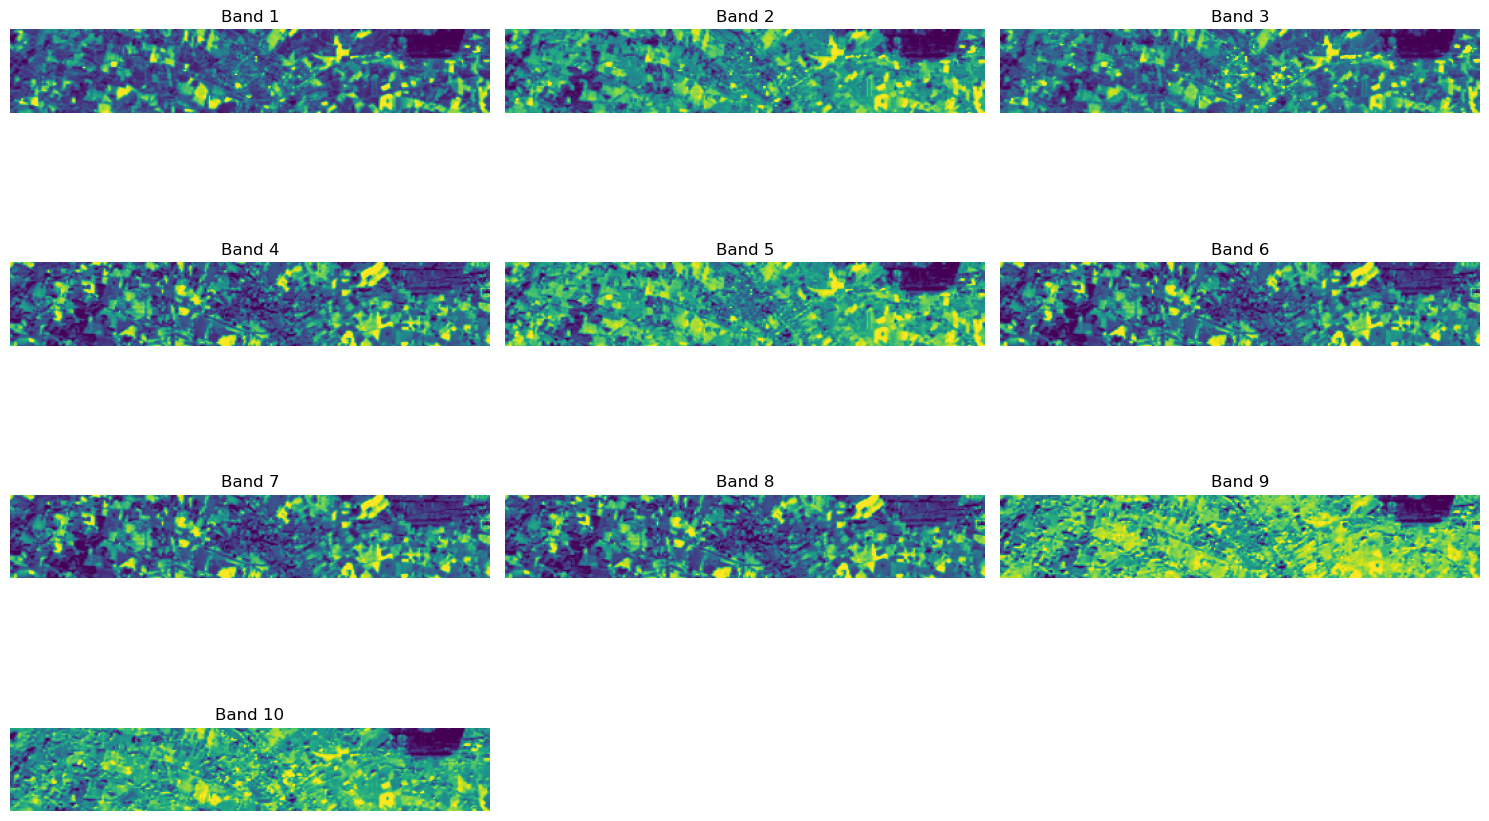

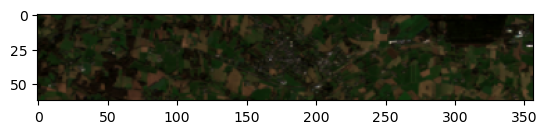

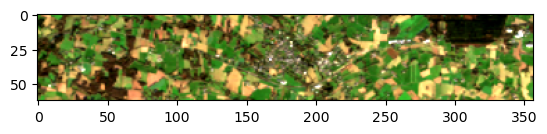

In [4]:
file_path = r"data_sentinel2\S2A_MSIL2A_20210131T111311_N0214_R137_T30UWU_20210131T135937.tif"

with rasterio.open(file_path) as src:
    # Print general metadata
    print(src.meta)
    
    
    
    # Print band-specific metadata (if available)
    for i in range(1, src.count + 1):
        print(f"Band {i} Metadata: {src.tags(i)}")
        
        
    def normalize(band):
        band_min, band_max = np.percentile(band, (2, 98))
        band_normalized = (band - band_min) / (band_max - band_min)
        band_normalized = np.clip(band_normalized, 0, 1)
        return band_normalized
    
    
    # Plot each band
    plt.figure(figsize=(15, 10))
    for i in range(1, src.count + 1):
        band = src.read(i)
        
        # Normalize the band using percentiles     
        band_normalized = normalize(band)
        
        # Plot the normalized band
        plt.subplot(4, 3, i)  # Adjust subplot layout based on the number of bands
        plt.imshow(band_normalized)
        plt.title(f'Band {i}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
        
        
    # visualise the image RGB
    band1 = src.read(1)  # Read the first band
    band2 = src.read(2)  # Read the second band
    band3 = src.read(3)  # Read the third band
    
    
    rgb=np.dstack((band1,band2,band3))
    rgb = rgb/np.max(rgb)
    plt.imshow(rgb)
    plt.show()
    
    # visualise the image RGB enhanced
    rgb_normalized = normalize(rgb)
    plt.imshow(rgb_normalized)
    plt.show()


The visualized Sentinel-2 imagery reveals distinctive spectral signatures across all 10 bands, with significant implications for wetland delineation. <br>

Image 1 displays normalized individual bands (1-10), where **Bands 5, 9, and 10** show notably higher contrast in what appear to be wetland features (bright yellow-green patterns). These bands likely represent near-infrared and short-wave infrared regions that effectively capture vegetation moisture content and water boundaries. <br>

Images 2 and 3 present RGB composites with Image 3 showing the enhanced normalized version. The **enhanced RGB composite** significantly improves wetland feature visibility, with clearer distinction between saturated areas (lighter green patches) and drier vegetation (darker regions). <br>

The metadata reveals **high dynamic range** in Bands 1-3 (with maximum values of 3270, 2955, and 2989 respectively), suggesting good radiometric resolution for feature extraction. The **standard deviation** is highest in Band 1 (235.72), indicating greater variability potentially useful for distinguishing wetland boundaries. <br>

For wetland segmentation, **Bands 5, 9, and 10** appear most promising due to their enhanced response to moisture content, while **Bands 3 and 8** show stronger vegetation structure information that could complement moisture data for comprehensive wetland classification.

# Load shape 

,OBJECTID,Id,HIC,date,ValPlat,NOM,ETIQ,ORIGINE,ECHELLE,PRODUCT,COMMENTA,VERSION,Shape_Leng,BV,Shape_Le_1,Shape_Area,FCT_ZH,geometry
0,1,0,None,2014,Vallée,None,None,Inventaire ZH DUP CERESA,0,None,04_ENTRANT\envoi_2017-07-04_CERESA,0,1412.387580,None,1412.387580,71226.920688,None,"POLYGON ((291663.536 6802656.432, 291650.493 6..."
1,2,0,None,2014,Vallée,None,None,Inventaire ZH DUP CERESA,0,None,04_ENTRANT\envoi_2017-07-04_CERESA,0,1609.331046,None,1609.331046,53848.477990,None,"POLYGON ((291916.19 6802941.374, 291935.24 680..."
2,3,0,None,2014,Vallée,None,None,Inventaire ZH DUP CERESA,0,None,04_ENTRANT\envoi_2017-07-04_CERESA,0,7821.146184,BV YVEL Hivet,7821.146184,389186.067742,None,"POLYGON ((297013.545 6801873.916, 296979.531 6..."
3,4,0,None,03-2016,Plateau,None,None,Inventaire ZH DUP CERESA,0,None,04_ENTRANT\envoi_2017-07-04_CERESA,0,8173.169245,BV YVEL Hivet,8173.169245,669964.024006,None,"POLYGON ((295933.074 6801950.359, 295921.868 6..."
4,5,0,None,2014,Vallée,None,None,Inventaire ZH DUP CERESA,0,None,04_ENTRANT\envoi_2017-07-04_CERESA,0,148.974550,BV YVEL Hivet,148.974550,1124.667978,ZH5,"POLYGON ((299843.548 6801796.729, 299864.715 6..."


<Axes: >

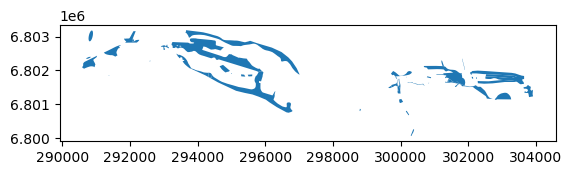

In [22]:
# Path to the shapefile (without the extension)
shapefile_path = r"emprise_zonehumide/NAZH_INVENTAIRE_ZH_Po.shp"

# Load the shapefile
gdf = gpd.read_file(shapefile_path)

# Print the first few rows of the attribute table
display(gdf.head())

# Plot the shapefile
gdf.plot()
# plt.title("Shapefile Visualization")
# plt.show()

**Wetland Inventory Shapefile Analysis** <br>

The visualization displays the **spatial distribution of wetland areas** (blue polygons) captured in the NAZH_INVENTAIRE_ZH_Po shapefile, with coordinate ranges of approximately 290,000-304,000 E and 6,800,000-6,803,000 N in what appears to be a UTM projection. <br>

The wetland inventory contains multiple disconnected polygons forming two distinct clusters - a **larger western cluster** and a **smaller eastern cluster**, potentially representing different wetland systems or inventory areas. <br>

The attribute table reveals this data originates from the **"Inventaire ZH DUP CERESA"** conducted primarily in **2014** with some additions in **2016**. Most wetlands are classified as **"Vallée"** (valley) type with one designated as **"Plateau"** type, indicating topographic position differences that influence hydrology. <br>

Several wetlands belong to the **"BV YVEL Hivet"** watershed, providing context for their hydrological connectivity. The presence of the **"FCT_ZH"** field (with one record showing "ZH5" classification) suggests functional categorization of wetlands, though most values are empty. <br>

This wetland inventory appears to be an official environmental dataset that would complement the Sentinel-2 imagery analysis for wetland segmentation, providing ground-truth validation data for remote sensing classification efforts.

# Check overlap

Shapefile CRS: EPSG:2154
Raster CRS: EPSG:3857
Reprojecting shapefile from EPSG:2154 to EPSG:3857


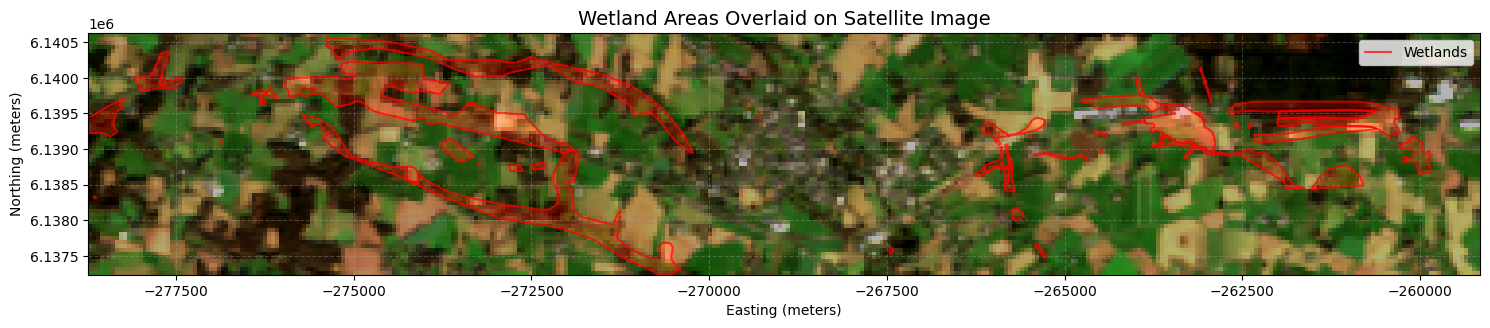

In [23]:

# Paths to the files
tif_path = r"data_sentinel2\S2A_MSIL2A_20210131T111311_N0214_R137_T30UWU_20210131T135937.tif"
shapefile_path = r"emprise_zonehumide/NAZH_INVENTAIRE_ZH_Po.shp"

# Load the shapefile
wetlands = gpd.read_file(shapefile_path)
print(f"Shapefile CRS: {wetlands.crs}")

# Open the raster file
with rasterio.open(tif_path) as src:
    print(f"Raster CRS: {src.crs}")
    
    # Get image data
    red = src.read(1)
    green = src.read(2)
    blue = src.read(3)
    
    # Create normalized RGB image
    rgb = np.dstack([red, green, blue])
    rgb_normalized = normalize(rgb)
    
    # Calculate precise image extent
    transform = src.transform
    rows, cols = red.shape
    left, top = transform * (0, 0)
    right, bottom = transform * (cols, rows)
    extent = [left, right, bottom, top]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Set plot extent
    ax.set_xlim(left, right)
    ax.set_ylim(bottom, top)
    
    # Plot the image
    ax.imshow(rgb_normalized, extent=extent)
    
    # Reproject shapefile to match raster CRS
    if wetlands.crs != src.crs:
        print(f"Reprojecting shapefile from {wetlands.crs} to {src.crs}")
        wetlands = wetlands.to_crs(src.crs)
    
    # Plot wetland boundaries
    wetlands.boundary.plot(
        ax=ax, 
        color='red', 
        linewidth=1.5,
        alpha=0.7, 
        label='Wetlands'
    )
    
    # Create wetland mask for visualization
    wetland_mask = geometry_mask(
        [geom for geom in wetlands.geometry],
        out_shape=(rows, cols),
        transform=transform,
        invert=True
    )
    
    # Optional: Overlay a semi-transparent mask
    ax.imshow(np.dstack([wetland_mask * 0.9, np.zeros_like(wetland_mask), np.zeros_like(wetland_mask)]), 
             alpha=0.3, extent=extent)
    
    #Add title and labels
    plt.title("Wetland Areas Overlaid on Satellite Image", fontsize=14)
    plt.xlabel('Easting (meters)')
    plt.ylabel('Northing (meters)')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

**Sentinel-2 Imagery with Wetland Inventory Overlay** <br>

The visualization demonstrates the spatial relationship between Sentinel-2 satellite imagery and officially inventoried wetland boundaries (red outlines) from the NAZH_INVENTAIRE_ZH_Po shapefile. <br>

**Coordinate system harmonization** was necessary in this preprocessing step, as the shapefile (originally in EPSG:2154, a French coordinate system) needed reprojection to match the satellite imagery (EPSG:3857, Web Mercator). This critical step ensures precise spatial alignment between remote sensing data and ground-truth reference data. <br>

This overlay visualization provides essential **reference data for model training and validation**, establishing ground-truth boundaries that will guide the wetland segmentation algorithm development. The semi-transparent red mask enhances visibility of wetland extents while maintaining the ability to see underlying spectral patterns in the satellite imagery.

# Visual satellite

**Interactive Wetland Visualization Tool Summary** <br>

The code implements a comprehensive **WetlandViewer** class creating an interactive interface for temporal analysis of wetlands using Sentinel-2 imagery and reference shapefiles. <br>

Key functionality includes **chronological organization** of satellite images by parsing dates from filenames, ensuring temporal analysis follows natural progression, and **coordinate system harmonization** between the satellite imagery (EPSG:3857) and wetland/study area shapefiles (EPSG:2154). <br>

The interface provides multiple visualization options through interactive widgets: **true color composites**, **individual spectral bands** (red, green, blue), **vector overlays** (wetland boundaries, study area), and **raster masks** highlighting wetland extents. These options enable different analytical perspectives of the same data. <br>

The tool incorporates extensive **metadata reporting** capabilities, including coordinate reference system details, spatial bounds comparison, pixel resolution metrics, and area calculations (total image area, study area, wetland area). These statistics provide critical context for wetland analysis. <br>

A particularly valuable feature is the **spatial overlap detection** between image extent and wetland boundaries, with warning messages when wetlands fall outside image boundaries. This prevents erroneous analysis and ensures data quality in the wetland segmentation workflow. <br>

This interactive tool represents an essential **exploratory preprocessing step** for wetland segmentation, allowing visual inspection of multiple temporal snapshots and validation of wetland feature signatures across different dates and visualization methods.

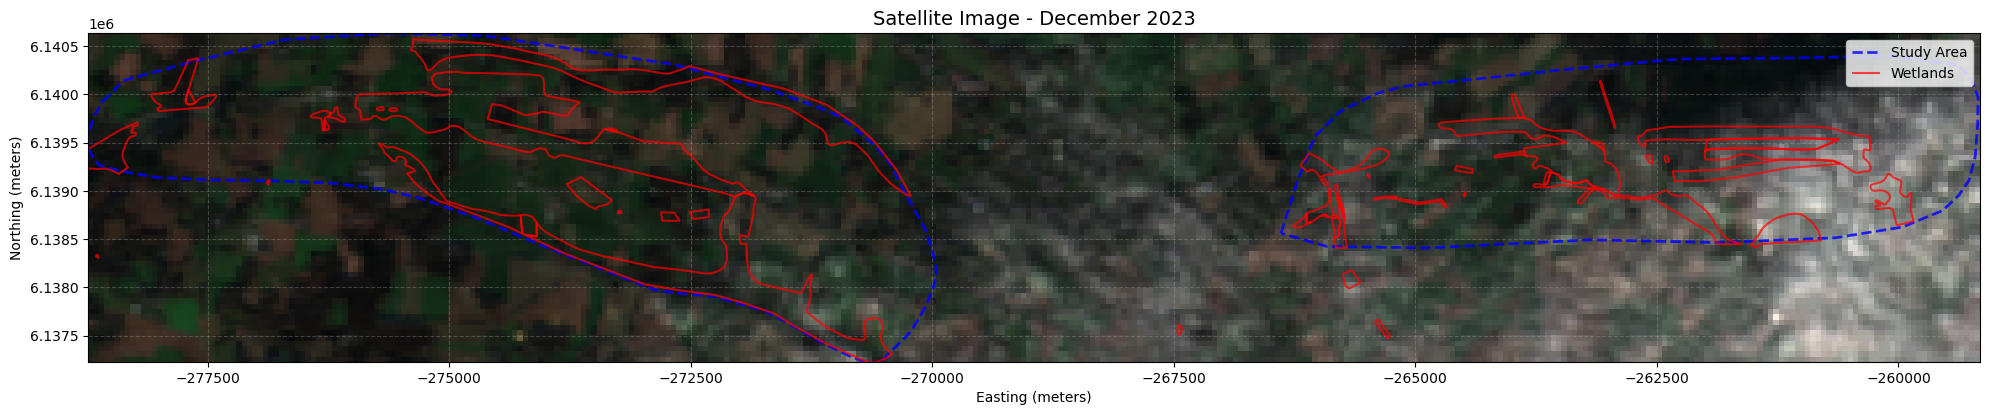

In [1]:
import os
import rasterio
from rasterio.mask import geometry_mask
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from datetime import datetime
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')

class WetlandViewer:
    def __init__(self, base_folder):
        self.base_folder = base_folder
        self.debug = True  # Set debug to True by default
        self.setup_data()
        self.create_widgets()
    
    def setup_data(self):
        """Load and setup initial data with chronologically ordered dates"""
        # Load shapefiles
        wetland_shp = os.path.join(self.base_folder, 'emprise_zonehumide', 'NAZH_INVENTAIRE_ZH_PO.shp')
        self.wetlands = gpd.read_file(wetland_shp)
        
        study_area_shp = os.path.join(self.base_folder, 'emprise_airedetude', 'PRAI_AE_RAPPR_PO.shp')
        self.study_area = gpd.read_file(study_area_shp)
        
        # Process TIFF files with proper date ordering
        tiff_folder = os.path.join(self.base_folder, 'data_sentinel2')
        tiff_files = [f for f in os.listdir(tiff_folder) if f.endswith('.tif')]
        
        # Create a list of (date, filename) tuples for sorting
        date_file_pairs = []
        for tiff_file in tiff_files:
            try:
                date_str = tiff_file.split('_')[2][:8]  # Extract date from filename
                date = datetime.strptime(date_str, '%Y%m%d')
                date_file_pairs.append((date, tiff_file))
            except (IndexError, ValueError) as e:
                print(f"Warning: Could not parse date from filename {tiff_file}: {e}")
                continue
        
        # Sort by date
        date_file_pairs.sort(key=lambda x: x[0])
        
        # Create ordered dictionary with chronological dates
        self.image_dict = OrderedDict()
        for date, tiff_file in date_file_pairs:
            display_date = date.strftime('%B %Y')  # Convert to "Month Year" format
            self.image_dict[display_date] = os.path.join(tiff_folder, tiff_file)
    
    def create_widgets(self):
        """Create and setup widgets"""
        self.month_dropdown = widgets.Dropdown(
            options=list(self.image_dict.keys()),
            description='Month:',
            style={'description_width': 'initial'}
        )
        
        self.layer_checkboxes = {
            'band1': widgets.Checkbox(description='Band 1 (Red)', value=False),
            'band2': widgets.Checkbox(description='Band 2 (Green)', value=False),
            'band3': widgets.Checkbox(description='Band 3 (Blue)', value=False),
            'true_color': widgets.Checkbox(description='True Color Image', value=True),
            'study_area': widgets.Checkbox(description='Study Area', value=True),
            'wetlands': widgets.Checkbox(description='Wetlands', value=True),
            'study_mask': widgets.Checkbox(description='Study Area Mask', value=False),
            'wetland_mask': widgets.Checkbox(description='Wetland Mask', value=False)
        }
        
        self.debug_toggle = widgets.Checkbox(
            value=True,  # Set to True by default
            description='Metadata statistics'
        )

        # Create layout with three rows of checkboxes
        band_container = widgets.HBox([
            self.layer_checkboxes['band1'],
            self.layer_checkboxes['band2'],
            self.layer_checkboxes['band3']
        ])
        
        vis_container = widgets.HBox([
            self.layer_checkboxes['true_color'],
            self.layer_checkboxes['study_area'],
            self.layer_checkboxes['wetlands']
        ])
        
        mask_container = widgets.HBox([
            self.layer_checkboxes['study_mask'],
            self.layer_checkboxes['wetland_mask']
        ])
        
        self.widget_container = widgets.VBox([
            widgets.HBox([self.month_dropdown, self.debug_toggle]),
            band_container,
            vis_container,
            mask_container
        ])

    def ensure_one_checkbox_selected(self, change):
        """Ensure at least one checkbox is selected"""
        if not any(checkbox.value for checkbox in self.layer_checkboxes.values()):
            change['owner'].value = True
    
    def update_plot(self, *args):
        """Update plot based on current widget states"""
        clear_output(wait=True)
        display(self.widget_container)
        
        selected_month = self.month_dropdown.value
        debug_mode = self.debug_toggle.value
        self.debug = debug_mode  # Update the class debug attribute
        
        # Print shapefile CRS information if debug mode is enabled
        if debug_mode:
            print("\n==== COORDINATE REFERENCE SYSTEM INFORMATION ====")
            print(f"Study Area Shapefile CRS: {self.study_area.crs}")
            print(f"Wetlands Shapefile CRS: {self.wetlands.crs}")
            
            # Also print the EPSG code more clearly if available
            try:
                study_area_epsg = self.study_area.crs.to_epsg()
                print(f"Study Area EPSG Code: {study_area_epsg}")
            except:
                print("Study Area EPSG Code: Not available")
                
            try:
                wetlands_epsg = self.wetlands.crs.to_epsg()
                print(f"Wetlands EPSG Code: {wetlands_epsg}")
            except:
                print("Wetlands EPSG Code: Not available")
        
        try:
            with rasterio.open(self.image_dict[selected_month]) as src:
                if debug_mode:
                    # Print satellite image CRS
                    print(f"Satellite Image CRS: {src.crs}")
                    try:
                        image_epsg = src.crs.to_epsg()
                        print(f"Satellite Image EPSG Code: {image_epsg}")
                    except:
                        print("Satellite Image EPSG Code: Not available")
                    
                    # Print bounds comparison for analysis
                    print("\n==== BOUNDS COMPARISON ====")
                    # Get image bounds in its native CRS
                    rows, cols = src.shape
                    left, top = src.transform * (0, 0)
                    right, bottom = src.transform * (cols, rows)
                    print(f"Image bounds [left, right, bottom, top]: [{left:.2f}, {right:.2f}, {bottom:.2f}, {top:.2f}]")
                    
                    # Get study area bounds in its native CRS
                    study_bounds = self.study_area.total_bounds
                    print(f"Study area bounds [minx, maxx, miny, maxy]: [{study_bounds[0]:.2f}, {study_bounds[2]:.2f}, {study_bounds[1]:.2f}, {study_bounds[3]:.2f}]")
                    
                    # Get wetlands bounds in its native CRS
                    wetland_bounds = self.wetlands.total_bounds
                    print(f"Wetlands bounds [minx, maxx, miny, maxy]: [{wetland_bounds[0]:.2f}, {wetland_bounds[2]:.2f}, {wetland_bounds[1]:.2f}, {wetland_bounds[3]:.2f}]")
                    
                    # Basic metadata
                    print("\n==== IMAGE METADATA ====")
                    print(f"Image shape: {src.shape}")
                    print(f"Total pixels: {src.shape[0] * src.shape[1]}")
                    print(f"Number of bands: {src.count}")
                    
                    # Calculate pixel sizes
                    pixel_width = abs(src.transform[0])
                    pixel_height = abs(src.transform[4])
                    pixel_area = pixel_width * pixel_height
                    
                    print(f"\nPixel Resolution:")
                    print(f"Width: {pixel_width:.2f} meters")
                    print(f"Height: {pixel_height:.2f} meters")
                    print(f"Area per pixel: {pixel_area:.2f} square meters")
                    
                    # Calculate area statistics
                    total_pixels = src.shape[0] * src.shape[1]
                    total_area = total_pixels * pixel_area
                    
                    try:
                        # Attempt to reproject and create masks for calculations
                        study_area_reprojected = self.study_area.to_crs(src.crs)
                        wetlands_reprojected = self.wetlands.to_crs(src.crs)
                        
                        # Print reprojected bounds for comparison
                        print("\n==== REPROJECTED BOUNDS COMPARISON ====")
                        study_bounds_proj = study_area_reprojected.total_bounds
                        print(f"Study area bounds (reprojected to image CRS): [{study_bounds_proj[0]:.2f}, {study_bounds_proj[2]:.2f}, {study_bounds_proj[1]:.2f}, {study_bounds_proj[3]:.2f}]")
                        
                        wetland_bounds_proj = wetlands_reprojected.total_bounds
                        print(f"Wetlands bounds (reprojected to image CRS): [{wetland_bounds_proj[0]:.2f}, {wetland_bounds_proj[2]:.2f}, {wetland_bounds_proj[1]:.2f}, {wetland_bounds_proj[3]:.2f}]")
                        
                        # Check for overlap with image
                        image_bbox = (left, bottom, right, top)
                        study_bbox = (study_bounds_proj[0], study_bounds_proj[1], study_bounds_proj[2], study_bounds_proj[3])
                        wetland_bbox = (wetland_bounds_proj[0], wetland_bounds_proj[1], wetland_bounds_proj[2], wetland_bounds_proj[3])
                        
                        # Simple overlap check
                        study_overlaps = (image_bbox[0] < study_bbox[2] and 
                                          image_bbox[2] > study_bbox[0] and 
                                          image_bbox[1] < study_bbox[3] and 
                                          image_bbox[3] > study_bbox[1])
                        
                        wetland_overlaps = (image_bbox[0] < wetland_bbox[2] and 
                                            image_bbox[2] > wetland_bbox[0] and 
                                            image_bbox[1] < wetland_bbox[3] and 
                                            image_bbox[3] > wetland_bbox[1])
                        
                        print(f"Study area overlaps with image: {study_overlaps}")
                        print(f"Wetlands overlap with image: {wetland_overlaps}")
                        
                        # Create masks for calculations
                        study_mask = geometry_mask(
                            [geom for geom in study_area_reprojected.geometry],
                            out_shape=src.shape,
                            transform=src.transform,
                            invert=True
                        )
                        wetland_mask = geometry_mask(
                            [geom for geom in wetlands_reprojected.geometry],
                            out_shape=src.shape,
                            transform=src.transform,
                            invert=True
                        )
                        
                        study_pixels = np.sum(study_mask)
                        wetland_pixels = np.sum(wetland_mask)
                        
                        study_area_m2 = study_pixels * pixel_area
                        wetland_area_m2 = wetland_pixels * pixel_area
                        
                        print(f"\nPixel Counts:")
                        print(f"Total pixel count: {total_pixels:,}")
                        print(f"Study area pixels: {study_pixels:,}")
                        print(f"Wetlands area pixels: {wetland_pixels:,}")
                        
                        print(f"\nArea Measurements:")
                        print(f"Total area: {total_area:,.2f} square meters")
                        print(f"Study area: {study_area_m2:,.2f} square meters")
                        print(f"Wetlands area: {wetland_area_m2:,.2f} square meters")
                        
                        # Explicitly note if areas appear outside the image
                        if study_pixels == 0:
                            print("\n⚠️ WARNING: Study area appears to be completely outside the image extent!")
                        
                        if wetland_pixels == 0:
                            print("⚠️ WARNING: Wetlands appear to be completely outside the image extent!")
                            
                    except Exception as e:
                        print(f"\nError calculating area statistics: {str(e)}")
                
                # Create figure
                fig, ax = plt.subplots(figsize=(20, 10))
                
                # Get image extent
                source = src.read(1)
                transform = src.transform
                rows, cols = source.shape
                left, top = transform * (0, 0)
                right, bottom = transform * (cols, rows)
                extent = [left, right, bottom, top]
                
                # Set plot extent
                ax.set_xlim(left, right)
                ax.set_ylim(bottom, top)

                if self.layer_checkboxes['true_color'].value:
                    # True color display
                    image = np.dstack([src.read(1), src.read(2), src.read(3)])
                    image = image / np.max(image)
                    ax.imshow(image, extent=extent)
                elif any([self.layer_checkboxes[f'band{i}'].value for i in range(1, 4)]):
                    # Individual band display
                    bands = []
                    for i in range(1, 4):
                        if self.layer_checkboxes[f'band{i}'].value:
                            band = src.read(i)
                            band = band / np.max(band)
                            bands.append(band)
                        else:
                            bands.append(np.zeros_like(src.read(1)))
                    image = np.dstack(bands)
                    ax.imshow(image, extent=extent)
                
                # Add masks if selected
                if self.layer_checkboxes['study_mask'].value:
                    study_mask = geometry_mask(
                        [geom for geom in self.study_area.to_crs(src.crs).geometry],
                        out_shape=src.shape,
                        transform=src.transform,
                        invert=True
                    )
                    ax.imshow(study_mask, extent=extent, alpha=0.3, cmap='cool')

                if self.layer_checkboxes['wetland_mask'].value:
                    wetland_mask = geometry_mask(
                        [geom for geom in self.wetlands.to_crs(src.crs).geometry],
                        out_shape=src.shape,
                        transform=src.transform,
                        invert=True
                    )
                    ax.imshow(wetland_mask, extent=extent, alpha=0.3, cmap='autumn')
                
                # Add boundaries if selected
                if self.layer_checkboxes['study_area'].value:
                    self.study_area.to_crs(src.crs).boundary.plot(
                        ax=ax, color='blue', linewidth=2, linestyle='--',
                        alpha=0.8, label='Study Area'
                    )
                
                if self.layer_checkboxes['wetlands'].value:
                    self.wetlands.to_crs(src.crs).boundary.plot(
                        ax=ax, color='red', linewidth=1.5,
                        alpha=0.7, label='Wetlands'
                    )
                
                # Add legend if needed
                if any([self.layer_checkboxes[key].value for key in ['study_area', 'wetlands', 'study_mask', 'wetland_mask']]):
                    ax.legend(loc='upper right')
                
                plt.title(f"Satellite Image - {selected_month}", fontsize=14)
                plt.xlabel('Easting (meters)')
                plt.ylabel('Northing (meters)')
                plt.grid(True, linestyle='--', alpha=0.3)
                plt.tight_layout()
                plt.show()
                
        except Exception as e:
            print(f"Error processing {selected_month}: {str(e)}")
            if debug_mode:
                import traceback
                traceback.print_exc()
    
    def display(self):
        """Display the interactive viewer"""
        # Add checkbox validation
        for checkbox in self.layer_checkboxes.values():
            checkbox.observe(self.ensure_one_checkbox_selected, names='value')
            checkbox.observe(self.update_plot, names='value')
        
        # Observe other widget changes
        self.month_dropdown.observe(self.update_plot, names='value')
        self.debug_toggle.observe(self.update_plot, names='value')
        
        display(self.widget_container)
        self.update_plot()

def interactive_aligned_viewer(base_folder):
    """Create and display interactive viewer"""
    viewer = WetlandViewer(base_folder)
    viewer.display()

# Example usage
if __name__ == "__main__":
    base_folder = "./"
    interactive_aligned_viewer(base_folder)

# Patches testing

**Data Preparation for Wetland Segmentation Model Training** <br>

This preprocessing pipeline demonstrates the critical image patching process essential for creating suitable training inputs for a wetland segmentation model. The workflow begins with **coordinate system alignment** (reprojecting from EPSG:2154 to EPSG:3857) followed by center cropping the satellite image and corresponding wetland mask to optimal dimensions (62×310 pixels). <br>

The patching process systematically divides the cropped data into **uniform 62×62 pixel squares** using the patchify library, resulting in 5 patches arranged horizontally across the image. This patch size strikes a balance between capturing sufficient wetland features while maintaining computational efficiency for model training. <br>


This patching approach effectively transforms the continuous satellite imagery into **structured training data** where each patch forms an independent input-target pair for deep learning. The binary mask conversion (wetland=1, non-wetland=0) creates clear classification targets for each pixel, enabling pixel-wise segmentation learning. <br>



Shapefile CRS: EPSG:2154
Raster CRS: EPSG:3857
Reprojecting shapefile from EPSG:2154 to EPSG:3857
Original image shape: (62, 357, 3)
Cropped image shape: (62, 310, 3)
Cropped mask shape: (62, 310)
RGB patches shape: (1, 5, 1, 62, 62, 3)
Mask patches shape: (1, 5, 62, 62)


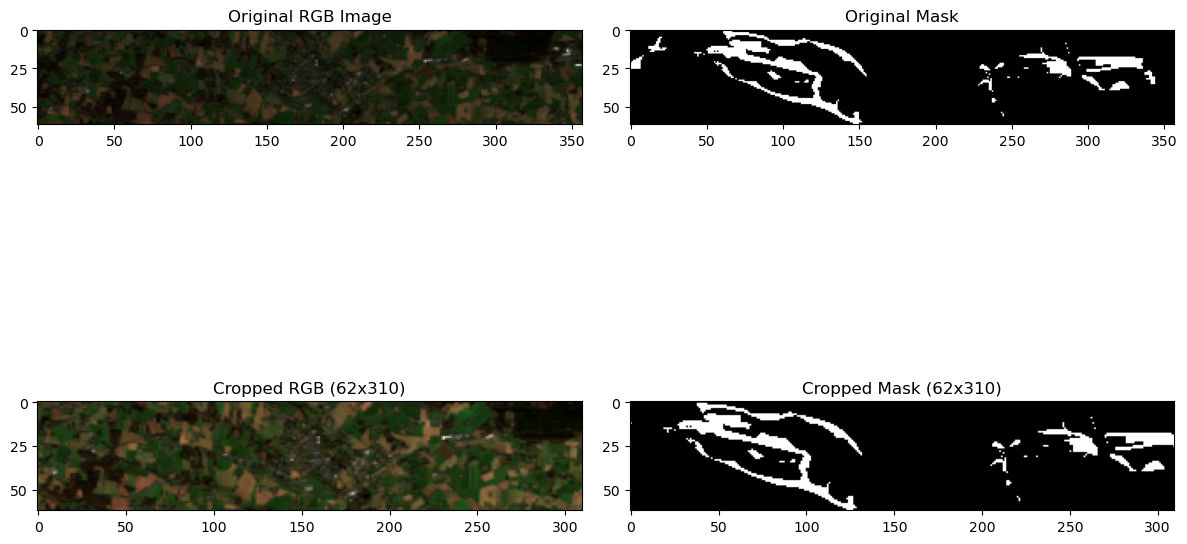

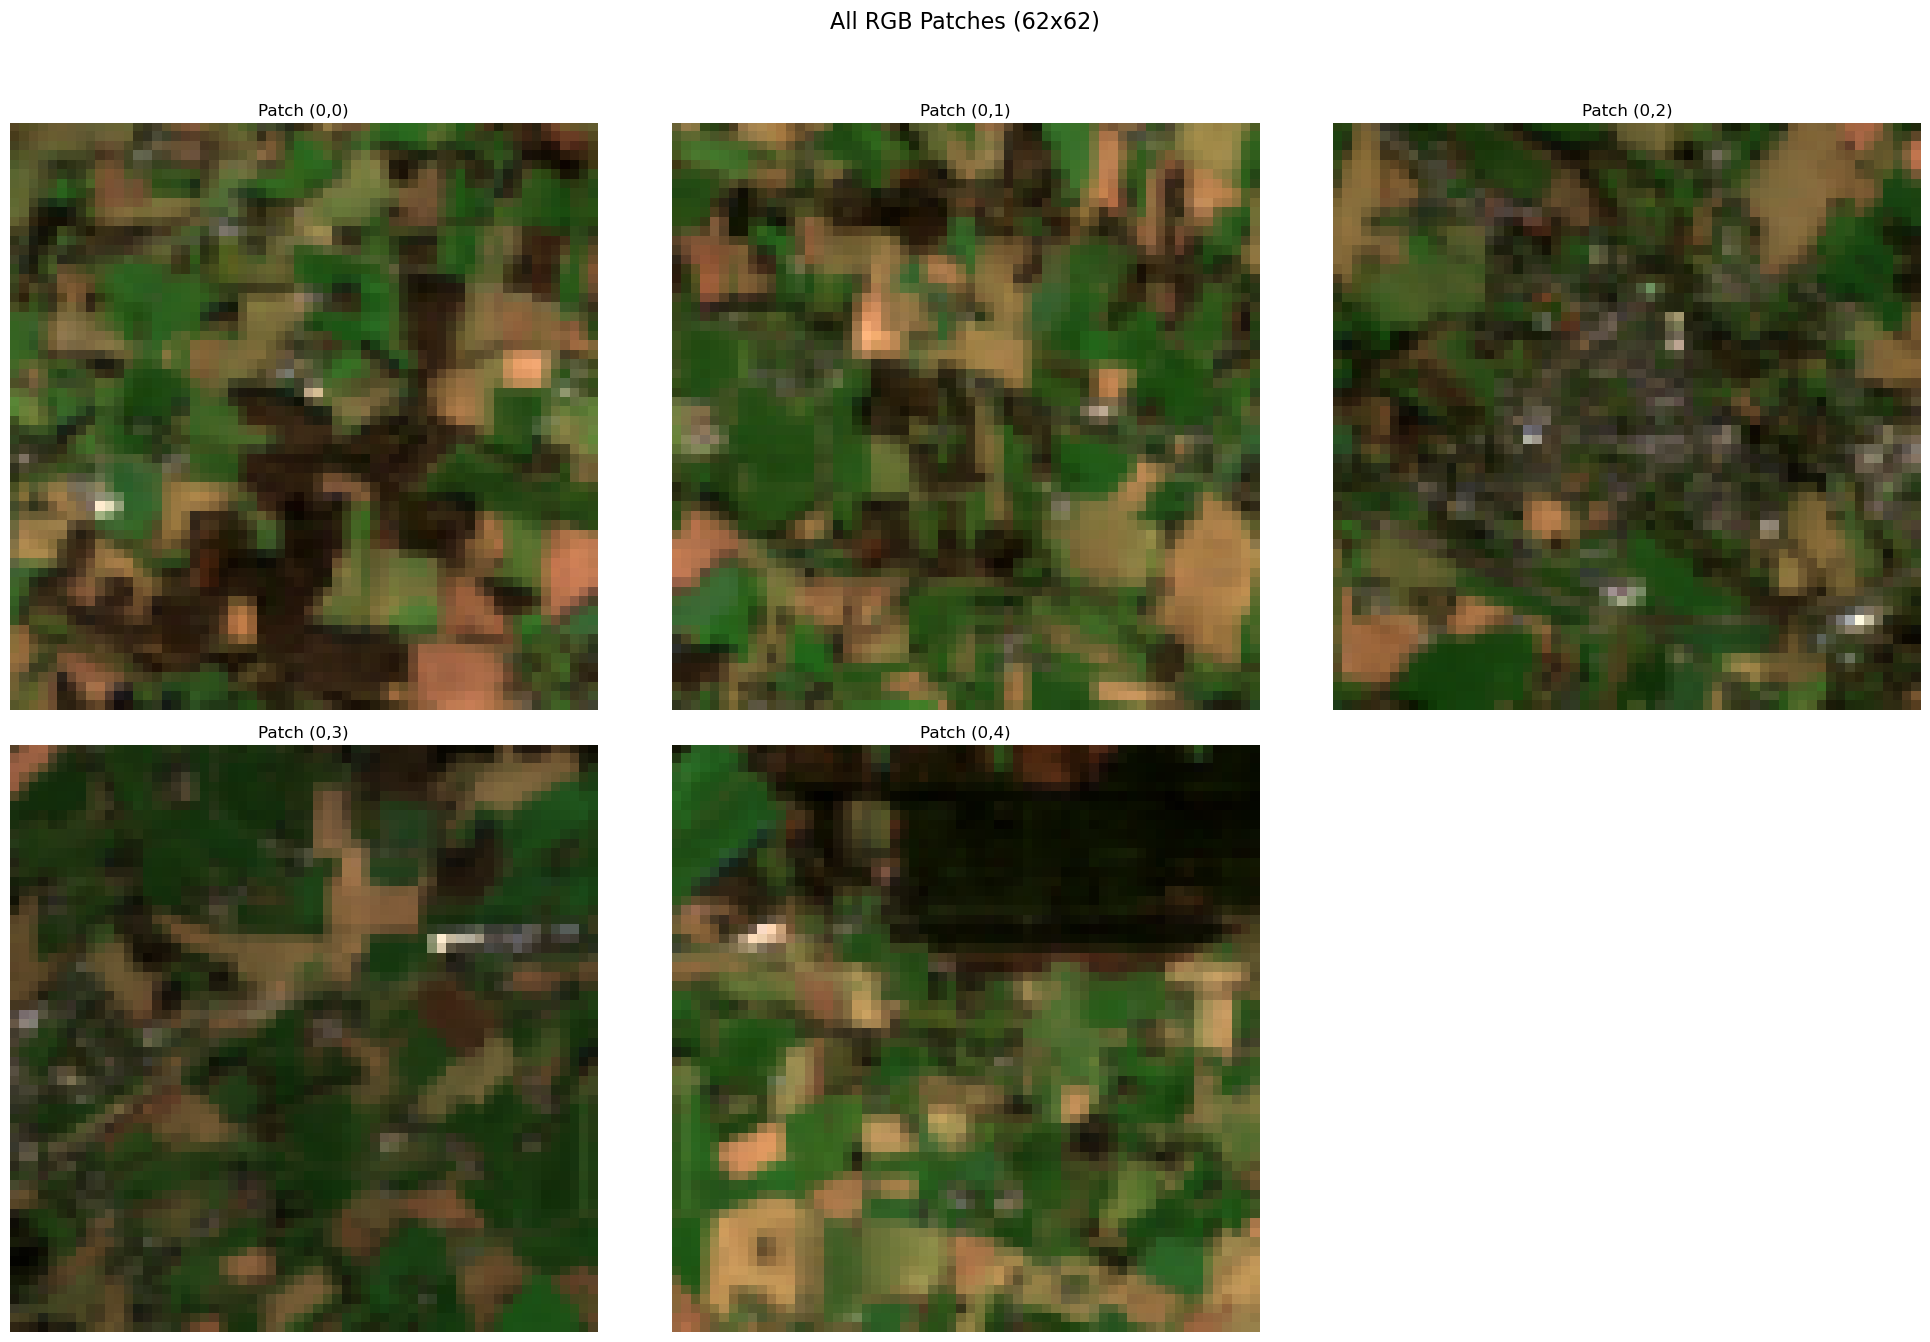

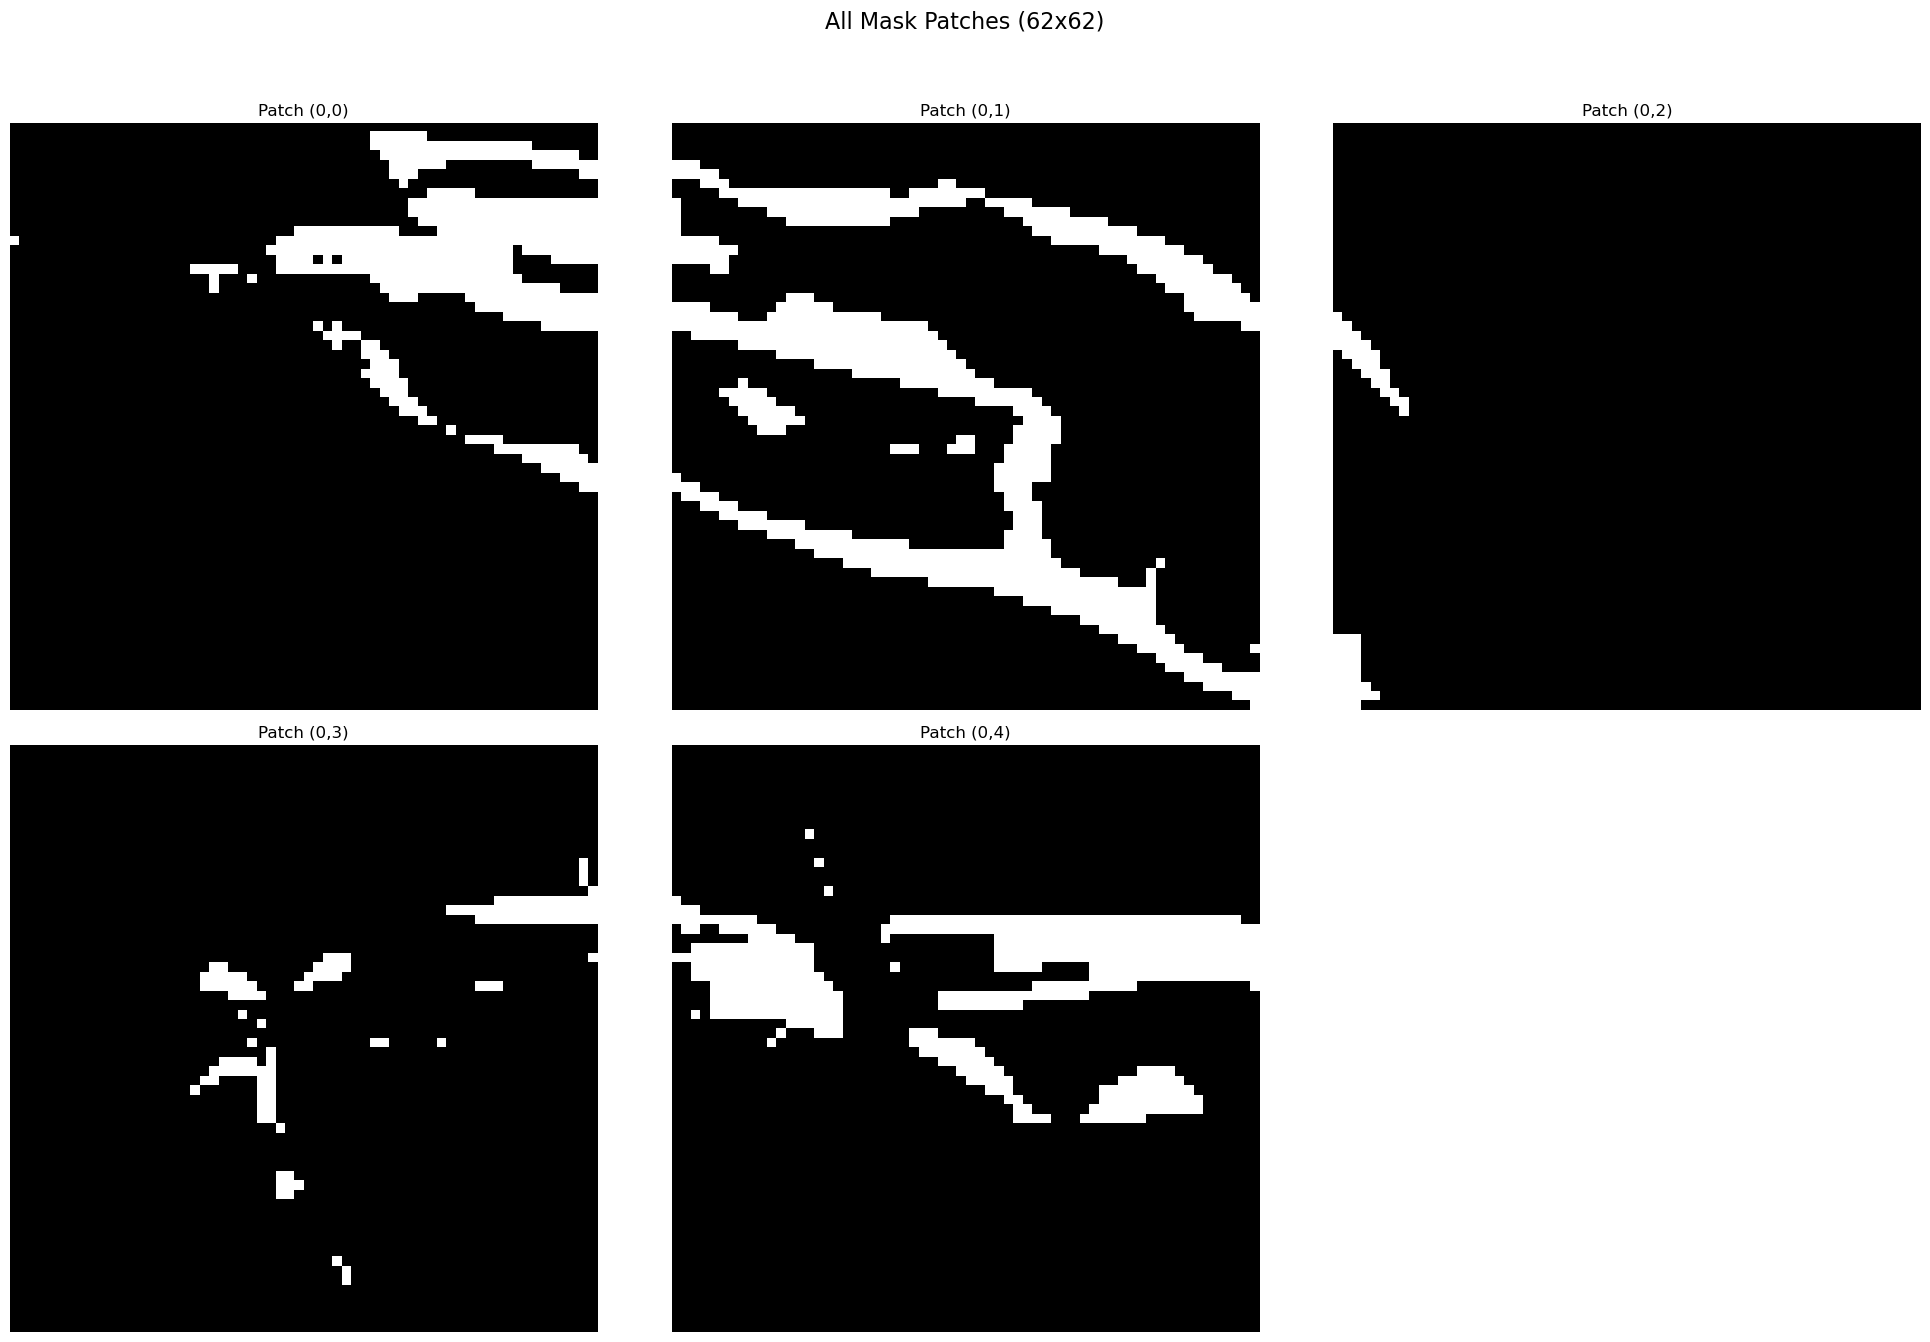

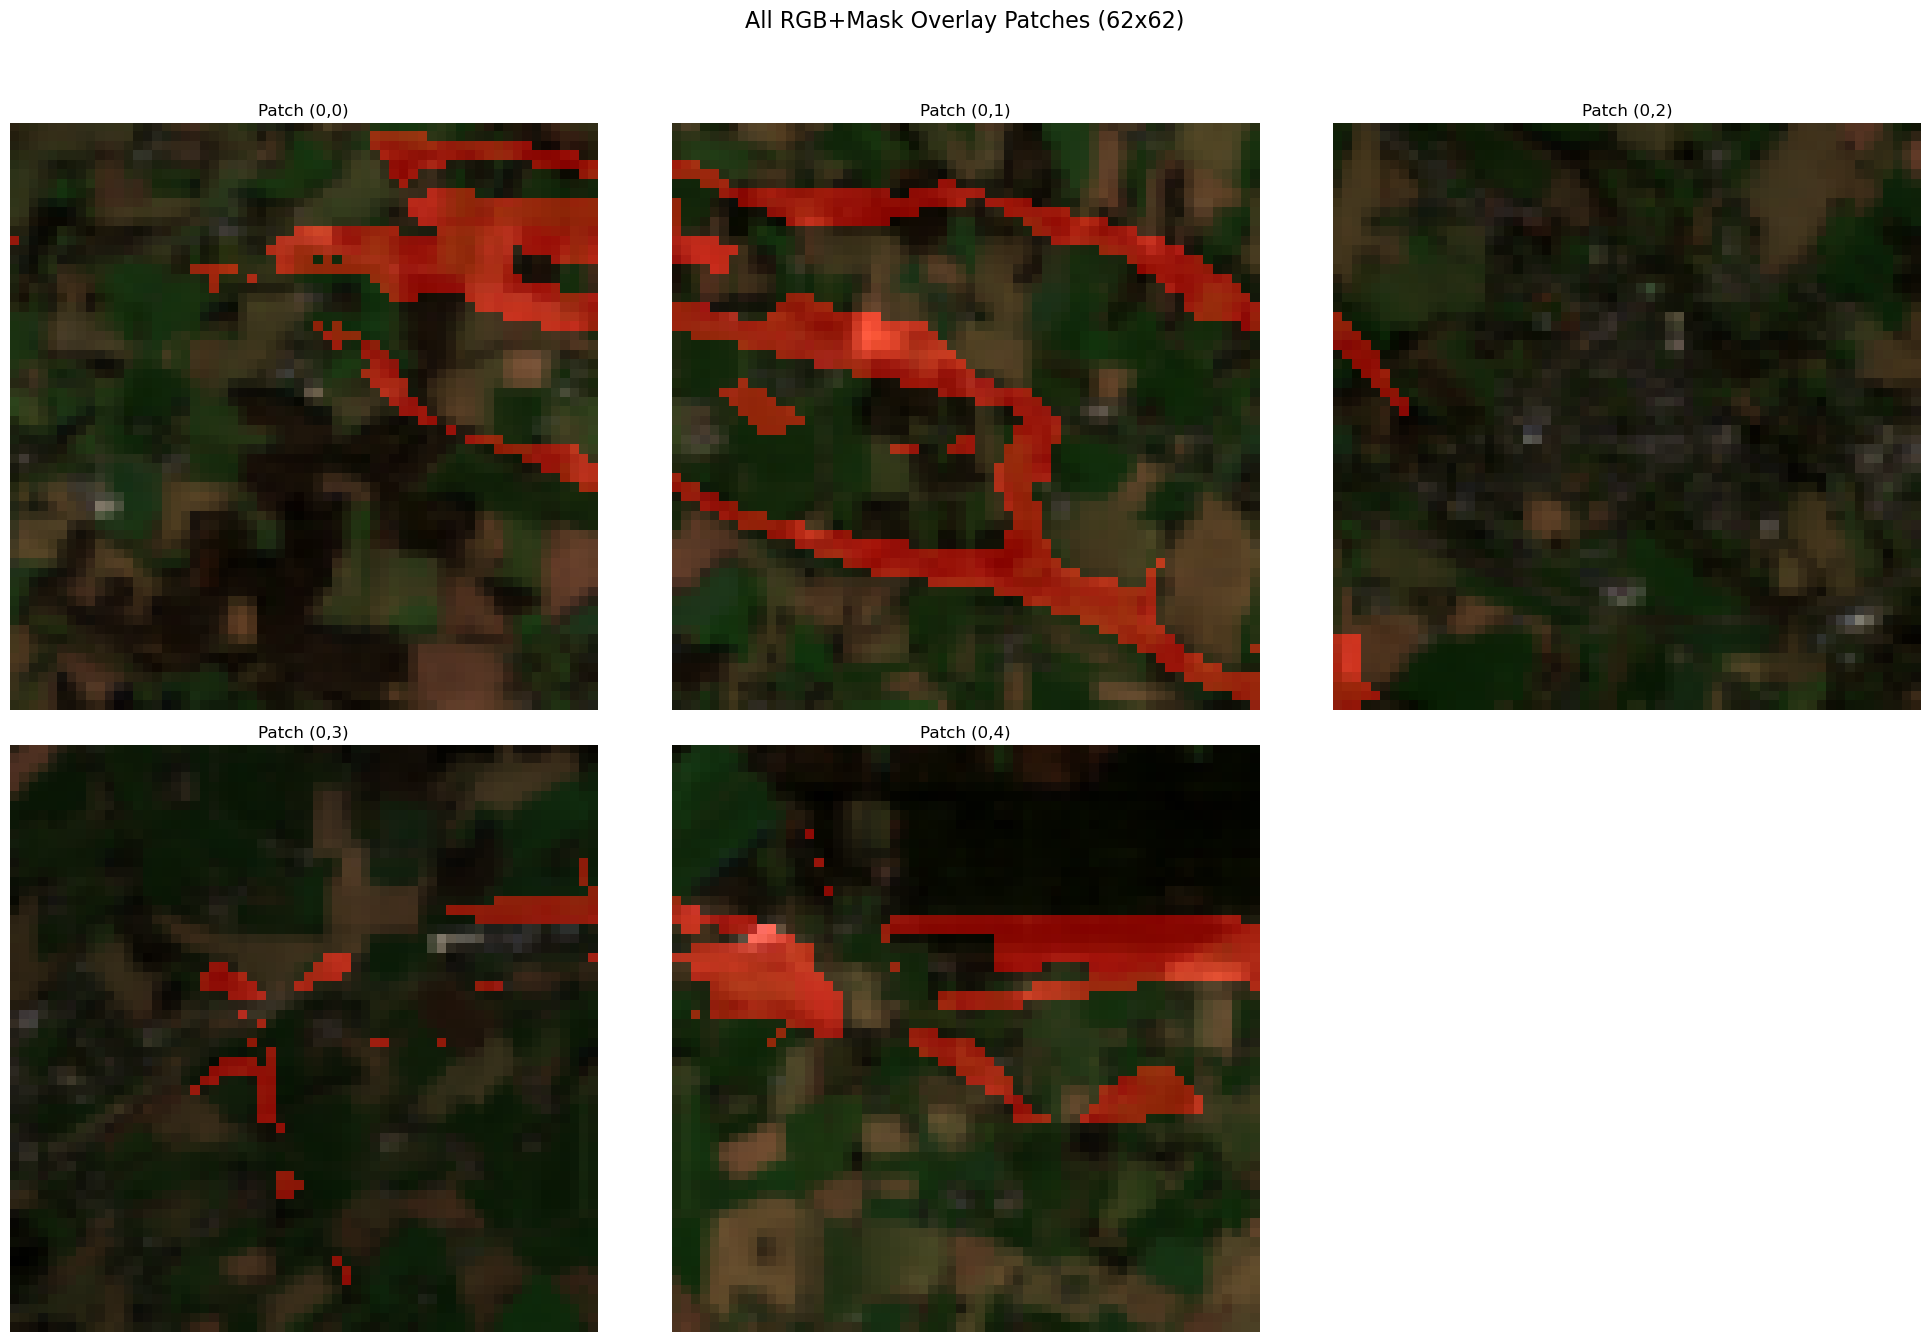

Total patches created: 5


In [25]:
import patchify
from patchify import patchify


def normalize(img):
    """Normalize image values to 0-1 range"""
    min_val = np.min(img)
    max_val = np.max(img)
    if max_val > min_val:
        return (img - min_val) / (max_val - min_val)
    return img

def center_crop(img, target_height, target_width):
    """Center crop an image to the target dimensions"""
    if len(img.shape) == 3:
        h, w, c = img.shape
    else:
        h, w = img.shape
        
    start_h = h // 2 - target_height // 2
    start_w = w // 2 - target_width // 2
    
    if len(img.shape) == 3:
        return img[start_h:start_h+target_height, start_w:start_w+target_width, :]
    else:
        return img[start_h:start_h+target_height, start_w:start_w+target_width]

def create_patches(img, patch_size):
    """Create patches from an image"""
    if len(img.shape) == 3:
        patches = patchify(img, (patch_size, patch_size, img.shape[2]), step=patch_size)
    else:
        patches = patchify(img, (patch_size, patch_size), step=patch_size)
    return patches

def main():
    # Paths to the files
    tif_path = r"data_sentinel2\S2A_MSIL2A_20210131T111311_N0214_R137_T30UWU_20210131T135937.tif"
    shapefile_path = r"emprise_zonehumide/NAZH_INVENTAIRE_ZH_Po.shp"
    
    # Parameters
    crop_height = 62
    crop_width = 310
    patch_size = 62
    
    # Load the shapefile (for mask creation)
    wetlands = gpd.read_file(shapefile_path)
    print(f"Shapefile CRS: {wetlands.crs}")
    
    # Open the raster file
    with rasterio.open(tif_path) as src:
        print(f"Raster CRS: {src.crs}")
        
        # Get image data
        red = src.read(1)
        green = src.read(2)
        blue = src.read(3)
        
        # Create RGB image
        rgb = np.dstack([red, green, blue])
        
        # Get image dimensions
        rows, cols = red.shape
        
        # Reproject shapefile to match raster CRS if needed
        if wetlands.crs != src.crs:
            print(f"Reprojecting shapefile from {wetlands.crs} to {src.crs}")
            wetlands = wetlands.to_crs(src.crs)
        
        # Create wetland mask
        wetland_mask = geometry_mask(
            [geom for geom in wetlands.geometry],
            out_shape=(rows, cols),
            transform=src.transform,
            invert=True  # True means areas inside geometries will be True
        ).astype(np.uint8)  # Convert boolean to 0/1 values
        
        # Center crop both input image and mask
        cropped_rgb = center_crop(rgb, crop_height, crop_width)
        cropped_mask = center_crop(wetland_mask, crop_height, crop_width)
        
        print(f"Original image shape: {rgb.shape}")
        print(f"Cropped image shape: {cropped_rgb.shape}")
        print(f"Cropped mask shape: {cropped_mask.shape}")
        
        # Create patches
        rgb_patches = create_patches(cropped_rgb, patch_size)
        mask_patches = create_patches(cropped_mask, patch_size)
        
        print(f"RGB patches shape: {rgb_patches.shape}")
        print(f"Mask patches shape: {mask_patches.shape}")
        
        # Calculate the number of patches
        num_patches_h = rgb_patches.shape[0]
        num_patches_w = rgb_patches.shape[1]
        total_patches = num_patches_h * num_patches_w
        
        # First, plot original and cropped images
        fig1, axes1 = plt.subplots(2, 2, figsize=(12, 10))
        
        # Original image and mask
        normalized_rgb = normalize(rgb)
        axes1[0, 0].imshow(normalized_rgb)
        axes1[0, 0].set_title("Original RGB Image")
        
        axes1[0, 1].imshow(wetland_mask, cmap='gray')
        axes1[0, 1].set_title("Original Mask")
        
        # Cropped image and mask
        normalized_cropped_rgb = normalize(cropped_rgb)
        axes1[1, 0].imshow(normalized_cropped_rgb)
        axes1[1, 0].set_title(f"Cropped RGB ({crop_height}x{crop_width})")
        
        axes1[1, 1].imshow(cropped_mask, cmap='gray')
        axes1[1, 1].set_title(f"Cropped Mask ({crop_height}x{crop_width})")
        
        plt.tight_layout()
        plt.show()
        
        # Now create a grid to display all patches
        # Calculate grid dimensions - try to make it roughly square
        grid_size = math.ceil(math.sqrt(total_patches))
        
        # Create subplots for RGB patches
        fig2 = plt.figure(figsize=(20, 20))
        fig2.suptitle(f"All RGB Patches ({patch_size}x{patch_size})", fontsize=16)
        
        # Plot all RGB patches
        patch_idx = 0
        for i in range(num_patches_h):
            for j in range(num_patches_w):
                patch_idx += 1
                if patch_idx <= total_patches:
                    ax = fig2.add_subplot(grid_size, grid_size, patch_idx)
                    patch_rgb = rgb_patches[i, j].squeeze()
                    normalized_patch_rgb = normalize(patch_rgb)
                    ax.imshow(normalized_patch_rgb)
                    ax.set_title(f"Patch ({i},{j})")
                    ax.axis('off')
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for suptitle
        plt.show()
        
        # Create subplots for mask patches
        fig3 = plt.figure(figsize=(20, 20))
        fig3.suptitle(f"All Mask Patches ({patch_size}x{patch_size})", fontsize=16)
        
        # Plot all mask patches
        patch_idx = 0
        for i in range(num_patches_h):
            for j in range(num_patches_w):
                patch_idx += 1
                if patch_idx <= total_patches:
                    ax = fig3.add_subplot(grid_size, grid_size, patch_idx)
                    patch_mask = mask_patches[i, j].squeeze()
                    ax.imshow(patch_mask, cmap='gray')
                    ax.set_title(f"Patch ({i},{j})")
                    ax.axis('off')
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        
        # Create subplots for RGB+Mask overlay patches
        fig4 = plt.figure(figsize=(20, 20))
        fig4.suptitle(f"All RGB+Mask Overlay Patches ({patch_size}x{patch_size})", fontsize=16)
        
        # Plot all overlay patches
        patch_idx = 0
        for i in range(num_patches_h):
            for j in range(num_patches_w):
                patch_idx += 1
                if patch_idx <= total_patches:
                    ax = fig4.add_subplot(grid_size, grid_size, patch_idx)
                    
                    # Get patches
                    patch_rgb = rgb_patches[i, j].squeeze()
                    patch_mask = mask_patches[i, j].squeeze()
                    normalized_patch_rgb = normalize(patch_rgb)
                    
                    # Create overlay
                    overlay = normalized_patch_rgb.copy()
                    if len(patch_mask.shape) == 2:  # If mask is 2D
                        # Add red overlay where mask is positive
                        overlay_mask = np.zeros_like(normalized_patch_rgb)
                        overlay_mask[..., 0] = patch_mask > 0  # Red channel
                        
                        # Blend the overlay with the RGB image
                        alpha = 0.5  # Transparency of the overlay
                        overlay = normalized_patch_rgb * (1 - alpha) + overlay_mask * alpha
                    
                    ax.imshow(overlay)
                    ax.set_title(f"Patch ({i},{j})")
                    ax.axis('off')
                    
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        
        print(f"Total patches created: {total_patches}")

if __name__ == "__main__":
    main()

# Create patches - Train , Validation and Test



This automated data processing workflow creates a comprehensive **multi-temporal wetland segmentation dataset** by processing 36 Sentinel-2 satellite images spanning 2021-2023, each containing all 10 spectral bands. The pipeline systematically handles coordinate system harmonization, spatial cropping, and patch generation. <br>

The dataset structure implements a **strategic 60/20/20 train/validation/test split** with 108 training patches, 36 validation patches, and 36 test patches, totaling 180 patches. This segmentation ensures **strict prevention of data leakage** by allocating specific spatial regions (columns 0-2 for training, column 3 for validation, column 4 for testing) so that test areas represent completely unseen geographic locations rather than just temporal variations. <br>

The **consistent date-based naming convention** (MMYYYYDD format extracted from filenames) enables temporal analysis while maintaining clear organization. Each patch maintains all 10 spectral bands, preserving the full information content for multi-spectral analysis of wetland characteristics. <br>

The structured folder hierarchy places input files (Sentinel-2 patches) in the "input" folder and corresponding binary wetland masks in the "output" folder within each dataset partition (train/val/test). This organization directly supports machine learning frameworks expecting paired input-target files for segmentation tasks. <br>



In [30]:
import re
from datetime import datetime
import os
import numpy as np
import rasterio
from rasterio.mask import geometry_mask
import geopandas as gpd
from patchify import patchify

def normalize(img):
    """Normalize image values to 0-1 range"""
    min_val = np.min(img)
    max_val = np.max(img)
    if max_val > min_val:
        return (img - min_val) / (max_val - min_val)
    return img

def center_crop(img, target_height, target_width):
    """Center crop an image to the target dimensions"""
    if len(img.shape) == 3:
        h, w, c = img.shape
    else:
        h, w = img.shape
        
    start_h = h // 2 - target_height // 2
    start_w = w // 2 - target_width // 2
    
    if len(img.shape) == 3:
        return img[start_h:start_h+target_height, start_w:start_w+target_width, :]
    else:
        return img[start_h:start_h+target_height, start_w:start_w+target_width]

def create_patches(img, patch_size):
    """Create patches from an image"""
    if len(img.shape) == 3:
        patches = patchify(img, (patch_size, patch_size, img.shape[2]), step=patch_size)
    else:
        patches = patchify(img, (patch_size, patch_size), step=patch_size)
    return patches

def extract_date_from_filename(filename):
    """Extract month, year, and day from S2 filename format"""
    # Example: S2A_MSIL2A_20210131T111311_N0214_R137_T30UWU_20210131T135937.tif
    # Format is typically YYYYMMDD
    match = re.search(r'_(\d{8})T', filename)
    if match:
        date_str = match.group(1)
        try:
            date_obj = datetime.strptime(date_str, '%Y%m%d')
            month = date_obj.month
            year = date_obj.year
            day = date_obj.day
            # Return in 'MMYYYYDD' format
            return f"{month:02d}{year}{day:02d}"
        except ValueError:
            return 'unknown'
    return 'unknown'

def process_tif_files(tif_folder, shapefile_path, output_folder):
    """Process all TIF files and their corresponding masks"""
    
    # Create output directory structure
    for dataset in ['train', 'val', 'test']:
        for subdir in ['input', 'output']:
            os.makedirs(os.path.join(output_folder, dataset, subdir), exist_ok=True)
    
    # Parameters
    crop_height = 62
    crop_width = 310
    patch_size = 62
    
    # Load the shapefile (for mask creation)
    print(f"Loading shapefile from {shapefile_path}")
    wetlands = gpd.read_file(shapefile_path)
    print(f"Shapefile CRS: {wetlands.crs}")
    
    # Get all TIF files in the folder
    tif_files = [f for f in os.listdir(tif_folder) if f.endswith('.tif')]
    print(f"Found {len(tif_files)} TIF files to process")
    
    # Process each TIF file
    for idx, tif_file in enumerate(tif_files):
        tif_path = os.path.join(tif_folder, tif_file)
        print(f"\nProcessing file {idx+1}/{len(tif_files)}: {tif_file}")
        
        # Extract full date (month, year, day) for filename
        full_date = extract_date_from_filename(tif_file)
        print(f"Extracted date: {full_date}")
        
        try:
            # Open the raster file
            with rasterio.open(tif_path) as src:
                print(f"Raster CRS: {src.crs}")
                print(f"Number of bands in source file: {src.count}")
                
                # Get all bands from the image
                all_bands = []
                for band_idx in range(1, src.count + 1):
                    print(f"Reading band {band_idx}...")
                    band = src.read(band_idx)
                    all_bands.append(band)
                
                # Stack all bands together
                multi_band_img = np.stack(all_bands, axis=2)  # Stack along the third dimension
                print(f"Multi-band image shape: {multi_band_img.shape} (Height, Width, Bands)")
                print(f"Number of bands preserved: {multi_band_img.shape[2]}")
                
                # Reproject shapefile to match raster CRS if needed
                if wetlands.crs != src.crs:
                    print(f"Reprojecting shapefile from {wetlands.crs} to {src.crs}")
                    reprojected_wetlands = wetlands.to_crs(src.crs)
                else:
                    reprojected_wetlands = wetlands
                
                # Create wetland mask
                print("Creating mask from shapefile...")
                wetland_mask = geometry_mask(
                    [geom for geom in reprojected_wetlands.geometry],
                    out_shape=(src.height, src.width),
                    transform=src.transform,
                    invert=True
                ).astype(np.uint8)
                
                # Center crop both input image and mask
                print(f"Center cropping to {crop_height}x{crop_width}...")
                cropped_multi_band = center_crop(multi_band_img, crop_height, crop_width)
                cropped_mask = center_crop(wetland_mask, crop_height, crop_width)
                
                print(f"Cropped multi-band image shape: {cropped_multi_band.shape}")
                print(f"Cropped mask shape: {cropped_mask.shape}")
                print(f"Bands preserved after cropping: {cropped_multi_band.shape[2]}")
                
                # Create patches
                print("Creating patches...")
                multi_band_patches = create_patches(cropped_multi_band, patch_size)
                mask_patches = create_patches(cropped_mask, patch_size)
                
                print(f"Multi-band patches shape: {multi_band_patches.shape}")
                print(f"Mask patches shape: {mask_patches.shape}")
                
                # Calculate number of patches
                if len(multi_band_patches.shape) == 6:  # Multi-band patches (1, columns, 1, h, w, bands)
                    num_columns = multi_band_patches.shape[1]
                    num_bands = multi_band_patches.shape[5]
                    print(f"Number of bands in patches: {num_bands}")
                else:
                    print("Unexpected multi-band patches shape. Skipping file.")
                    continue
                
                print(f"Number of patch columns: {num_columns}")
                
                # Distribute patches into train, val, test sets
                for col in range(num_columns):
                    # Determine dataset based on column index
                    if col < 3:  # Columns 0, 1, 2
                        dataset = 'train'
                    elif col == 3:  # Column 3
                        dataset = 'val'
                    else:  # Column 4
                        dataset = 'test'
                    
                    # Get patch number (for sequential naming within dataset)
                    patch_num = col
                    if dataset == 'val':
                        patch_num = 0  # Reset for validation set
                    elif dataset == 'test':
                        patch_num = 0  # Reset for test set
                    
                    # Extract the patches
                    if len(multi_band_patches.shape) == 6:  # Multi-band patches (1, columns, 1, h, w, bands)
                        multi_band_patch = multi_band_patches[0, col, 0]  # Shape: (62, 62, bands)
                        print(f"Patch shape: {multi_band_patch.shape} - Contains {multi_band_patch.shape[2]} bands")
                    else:
                        print(f"Unexpected multi-band patch shape. Skipping column {col}.")
                        continue
                    
                    if len(mask_patches.shape) == 4:  # Mask patches (1, columns, h, w)
                        mask_patch = mask_patches[0, col]  # Shape: (62, 62)
                    else:
                        print(f"Unexpected mask patch shape. Skipping column {col}.")
                        continue
                    
                    # Construct filenames with full date format
                    multi_band_filename = f"{dataset}_{full_date}_p{patch_num+1}.tif"
                    mask_filename = f"{dataset}_{full_date}_p{patch_num+1}.tif"
                    
                    # Paths for saving
                    multi_band_output_path = os.path.join(output_folder, dataset, 'input', multi_band_filename)
                    mask_output_path = os.path.join(output_folder, dataset, 'output', mask_filename)
                    
                    print(f"Saving {dataset} patch {patch_num+1} to {multi_band_output_path}")
                    print(f"  - Contains {num_bands} bands")
                    
                    # Get raster profile for saving
                    profile = src.profile.copy()
                    profile.update(
                        driver='GTiff',
                        height=patch_size,
                        width=patch_size,
                        count=num_bands  # Update count to number of bands
                    )
                    
                    # Save multi-band patch
                    with rasterio.open(multi_band_output_path, 'w', **profile) as dst:
                        for band_idx in range(num_bands):
                            band_data = multi_band_patch[:, :, band_idx]
                            dst.write(band_data, band_idx + 1)
                            
                        print(f"  - Saved multi-band patch with {dst.count} bands")
                    
                    # Verify bands were saved correctly
                    with rasterio.open(multi_band_output_path, 'r') as verification:
                        print(f"  - Verification: Saved file has {verification.count} bands")
                    
                    # Update profile for mask (single channel)
                    profile.update(count=1)
                    
                    # Save mask patch
                    with rasterio.open(mask_output_path, 'w', **profile) as dst:
                        dst.write(mask_patch, 1)
                
                print(f"Completed processing {tif_file}")
        
        except Exception as e:
            print(f"Error processing {tif_file}: {str(e)}")
            continue
    
    print("\nProcessing complete!")
    print(f"Data saved to {output_folder} with the following structure:")
    print(f"  - {output_folder}/train/input/ - Training input patches (with all bands preserved)")
    print(f"  - {output_folder}/train/output/ - Training mask patches")
    print(f"  - {output_folder}/val/input/ - Validation input patches (with all bands preserved)")
    print(f"  - {output_folder}/val/output/ - Validation mask patches")
    print(f"  - {output_folder}/test/input/ - Test input patches (with all bands preserved)")
    print(f"  - {output_folder}/test/output/ - Test mask patches")

def main():
    # Define paths
    tif_folder = r"data_sentinel2"  # Folder containing all TIF files
    shapefile_path = r"emprise_zonehumide/NAZH_INVENTAIRE_ZH_Po.shp"
    output_folder = r"patches_data_allbands"  # Root folder for dataset
    
    # Process all TIF files
    process_tif_files(tif_folder, shapefile_path, output_folder)
    
if __name__ == "__main__":
    main()

Loading shapefile from emprise_zonehumide/NAZH_INVENTAIRE_ZH_Po.shp
Shapefile CRS: EPSG:2154
Found 36 TIF files to process

Processing file 1/36: S2A_MSIL2A_20210131T111311_N0214_R137_T30UWU_20210131T135937.tif
Extracted date: 01202131
Raster CRS: EPSG:3857
Number of bands in source file: 10
Reading band 1...
Reading band 2...
Reading band 3...
Reading band 4...
Reading band 5...
Reading band 6...
Reading band 7...
Reading band 8...
Reading band 9...
Reading band 10...
Multi-band image shape: (62, 357, 10) (Height, Width, Bands)
Number of bands preserved: 10
Reprojecting shapefile from EPSG:2154 to EPSG:3857
Creating mask from shapefile...
Center cropping to 62x310...
Cropped multi-band image shape: (62, 310, 10)
Cropped mask shape: (62, 310)
Bands preserved after cropping: 10
Creating patches...
Multi-band patches shape: (1, 5, 1, 62, 62, 10)
Mask patches shape: (1, 5, 62, 62)
Number of bands in patches: 10
Number of patch columns: 5
Patch shape: (62, 62, 10) - Contains 10 bands
Savin

# Cloudy images

**Cloud Detection Preprocessing for Wetland Segmentation Dataset** <br>

This preprocessing step identifies and labels cloudy Sentinel-2 image patches that could negatively impact wetland segmentation model performance. The script analyzes **35 manually identified cloudy patches** across the train, validation, and test sets, creating a comprehensive cloud detection dataset. <br>

The core methodology uses **Coefficient of Variation (CV)** calculated on normalized spectral bands as the primary feature for cloud identification. This statistical approach quantifies image texture variability, as clouds typically show distinctive CV patterns compared to clear wetland imagery. <br>

The visual evidence from the feature table demonstrates how spectral bands respond differently to cloud presence - rows labeled "cloudy" (like rows 6-7) show distinct CV patterns compared to "non_cloudy" rows. The **higher CV values** in cloudy patches indicate greater pixel intensity variations, particularly noticeable in bands 2-4. <br>

This cloud detection preprocessing is essential for data quality assurance, as it enables **filtering or special handling of cloudy images** during model training to prevent atmospheric interference from compromising wetland feature detection. The resulting CSV file provides a valuable reference for downstream model development, allowing integration of cloud presence as a data quality indicator. <br>

The implementation ensures operational efficiency through normalized path handling and intelligent error management, making it robust for processing the complete 180-patch dataset spanning multiple years of observations.

In [ ]:
import os
import numpy as np
import pandas as pd
import rasterio
import glob
from pathlib import Path

# Define cloudy files list
cloudy_files = [
    "patches_data_allbands/train/input/train_10202228_p2.tif",
    "patches_data_allbands/val/input/val_04202301_p1.tif",
    "patches_data_allbands/val/input/val_12202327_p1.tif",
    "patches_data_allbands/val/input/val_05202301_p1.tif",
    "patches_data_allbands/train/input/train_05202131_p1.tif",
    "patches_data_allbands/train/input/train_08202329_p3.tif",
    "patches_data_allbands/train/input/train_01202231_p3.tif",
    "patches_data_allbands/train/input/train_10202228_p3.tif",
    "patches_data_allbands/train/input/train_05202201_p3.tif",
    "patches_data_allbands/train/input/train_05202131_p2.tif",
    "patches_data_allbands/train/input/train_01202231_p1.tif",
    "patches_data_allbands/train/input/train_05202131_p3.tif",
    "patches_data_allbands/train/input/train_12202327_p3.tif",
    "patches_data_allbands/test/input/test_10202228_p1.tif",
    "patches_data_allbands/train/input/train_07202330_p2.tif",
    "patches_data_allbands/train/input/train_05202301_p3.tif",
    "patches_data_allbands/test/input/test_07202330_p1.tif",
    "patches_data_allbands/val/input/val_10202228_p1.tif",
    "patches_data_allbands/train/input/train_11202327_p1.tif", # good cloudy example
    "patches_data_allbands/test/input/test_01202231_p1.tif",
    "patches_data_allbands/val/input/val_06202130_p1.tif",
    "patches_data_allbands/train/input/train_07202330_p1.tif",
    "patches_data_allbands/val/input/val_01202231_p1.tif",
    "patches_data_allbands/train/input/train_04202301_p2.tif",
    "patches_data_allbands/val/input/val_08202329_p1.tif",
    "patches_data_allbands/test/input/test_07202130_p1.tif",
    "patches_data_allbands/train/input/train_01202231_p2.tif",
    "patches_data_allbands/train/input/train_08202329_p1.tif",
    "patches_data_allbands/test/input/test_12202327_p1.tif",
    "patches_data_allbands/train/input/train_01202331_p1.tif",
    "patches_data_allbands/train/input/train_04202301_p3.tif",
    "patches_data_allbands/train/input/train_11202327_p2.tif",
    "patches_data_allbands/train/input/train_05202301_p1.tif",
    "patches_data_allbands/train/input/train_05202301_p2.tif",
    "patches_data_allbands/test/input/test_05202301_p1.tif"
]

# Convert cloudy files to set of normalized paths for efficient lookup
cloudy_files_set = {os.path.normpath(f).replace('\\', '/') for f in cloudy_files}

def is_cloudy(file_path):
    """Check if the file is in the cloudy files list"""
    normalized_path = os.path.normpath(file_path).replace('\\', '/')
    return normalized_path in cloudy_files_set

def normalize(band):
    """Normalize band values using 2-98 percentile range"""
    # Handle potential NaN or inf values
    band_cleaned = band[np.isfinite(band)]
    if len(band_cleaned) == 0:
        return band
        
    # Use percentiles to avoid outliers
    band_min, band_max = np.percentile(band_cleaned, (2, 98))
    
    # Avoid division by zero
    if band_max == band_min:
        return np.zeros_like(band)
        
    band_normalized = (band - band_min) / (band_max - band_min)
    band_normalized = np.clip(band_normalized, 0, 1)
    return band_normalized

def calculate_cv(band):
    """Calculate coefficient of variation (CV) for a band"""
    # First normalize the band
    band_normalized = normalize(band)
    
    # Handle potential NaN or inf values
    band_cleaned = band_normalized[np.isfinite(band_normalized)]
    if len(band_cleaned) == 0:
        return 0
    
    # Get mean and std dev
    mean = np.mean(band_cleaned)
    
    # Guard against division by zero or very small means
    if abs(mean) < 1e-10:
        return 0
        
    std = np.std(band_cleaned)
    cv = (std / mean)  # CV as percentage
    return cv

def process_tif_file(file_path):
    """Process a TIF file and extract CV for each band"""
    with rasterio.open(file_path) as src:
        # Get number of bands
        num_bands = src.count
        
        # Calculate CV for each band
        band_cvs = []
        for band_idx in range(1, num_bands + 1):
            band = src.read(band_idx)
            cv = calculate_cv(band)
            band_cvs.append(cv)
        
        return band_cvs

def create_cloud_dataframe():
    """Create dataframe with band CVs and cloud labels for all images"""
    # Get all TIF files in the dataset directories
    base_dir = "patches_data_allbands"
    tif_files = []
    
    for subset in ["train", "val", "test"]:
        input_dir = os.path.join(base_dir, subset, "input")
        if os.path.exists(input_dir):
            tif_files.extend(glob.glob(os.path.join(input_dir, "*.tif")))
    
    # Create lists to store data
    filenames = []
    labels = []
    all_band_cvs = []
    
    # Process each file
    print(f"Processing {len(tif_files)} TIF files...")
    
    for file_idx, file_path in enumerate(tif_files):
        if (file_idx + 1) % 10 == 0:
            print(f"Processed {file_idx + 1}/{len(tif_files)} files")
            
        try:
            # Get CV values for each band
            band_cvs = process_tif_file(file_path)
            
            # Determine if the image is cloudy
            is_cloudy_image = is_cloudy(file_path)
            
            # Store data
            filenames.append(file_path)
            labels.append("cloudy" if is_cloudy_image else "non_cloudy")
            all_band_cvs.append(band_cvs)
            
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    
    # Create DataFrame
    data = {"filename": filenames, "label": labels}
    
    # Add band CV columns (if we have data)
    if all_band_cvs and len(all_band_cvs[0]) > 0:
        num_bands = len(all_band_cvs[0])
        for band_idx in range(num_bands):
            data[f"band{band_idx+1}_cv"] = [cvs[band_idx] if band_idx < len(cvs) else np.nan 
                                            for cvs in all_band_cvs]
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Print summary
    print(f"\nDataFrame created with {len(df)} rows")
    print(f"Number of cloudy images: {sum(df['label'] == 'cloudy')}")
    print(f"Number of non-cloudy images: {sum(df['label'] == 'non_cloudy')}")
    
    return df

# Execute if run as a script
if __name__ == "__main__":
    # Create the cloud detection dataframe
    cloud_df = create_cloud_dataframe()
    
    # Save to CSV
    output_file = "cloud_detection_cv_features.csv"
    cloud_df.to_csv(output_file, index=False)
    print(f"DataFrame saved to {output_file}")
    
    # Display first few rows
    print("\nFirst 5 rows of the DataFrame:")
    display(cloud_df)

Processing 180 TIF files...
Processed 10/180 files
Processed 20/180 files
Processed 30/180 files
Processed 40/180 files
Processed 50/180 files
Processed 60/180 files
Processed 70/180 files
Processed 80/180 files
Processed 90/180 files
Processed 100/180 files
Processed 110/180 files
Processed 120/180 files
Processed 130/180 files
Processed 140/180 files
Processed 150/180 files
Processed 160/180 files
Processed 170/180 files
Processed 180/180 files

DataFrame created with 180 rows
Number of cloudy images: 35
Number of non-cloudy images: 145
DataFrame saved to cloud_detection_cv_features.csv

First 5 rows of the DataFrame:


,filename,label,band1_cv,band2_cv,band3_cv,band4_cv,band5_cv,band6_cv,band7_cv,band8_cv,band9_cv,band10_cv
0,patches_data_allbands\train\input\train_012021...,non_cloudy,0.749454,0.534968,0.607622,0.677047,0.495132,0.673148,0.698241,0.666222,0.410691,0.437061
1,patches_data_allbands\train\input\train_012021...,non_cloudy,0.827541,0.474836,0.658222,0.642991,0.431682,0.618515,0.647389,0.638145,0.381479,0.437260
2,patches_data_allbands\train\input\train_012021...,non_cloudy,0.730149,0.526752,0.656879,0.667925,0.502097,0.667615,0.681988,0.653856,0.408322,0.453174
3,patches_data_allbands\train\input\train_012022...,non_cloudy,0.683272,0.529808,0.591218,0.709500,0.493909,0.713287,0.725809,0.692501,0.422201,0.476320
4,patches_data_allbands\train\input\train_012022...,non_cloudy,0.722738,0.464056,0.582715,0.695930,0.436844,0.701254,0.706152,0.675082,0.402913,0.496565
...,...,...,...,...,...,...,...,...,...,...,...,...
175,patches_data_allbands\test\input\test_10202328...,non_cloudy,0.913942,0.726940,0.856053,0.602453,0.671555,0.592306,0.626593,0.599219,0.583937,0.766429
176,patches_data_allbands\test\input\test_11202127...,non_cloudy,0.717757,0.585745,0.692225,0.716566,0.521886,0.737632,0.733925,0.696130,0.476299,0.525239
177,patches_data_allbands\test\input\test_11202227...,non_cloudy,0.769370,0.582962,0.654913,0.762518,0.541135,0.759005,0.787400,0.757885,0.488894,0.558327
178,patches_data_allbands\test\input\test_11202327...,non_cloudy,0.836916,0.613170,0.738751,0.737347,0.561914,0.758510,0.774413,0.726588,0.500814,0.593580


## Cloudy image statistical test

**Statistical Validation of Cloud Detection Features** <br>

This analysis provides statistical validation for the cloud detection methodology by examining which spectral bands exhibit significant differences between cloudy and non-cloudy patches. Using rigorous ANOVA testing and effect size calculations (Cohen's d), the results reveal a clear pattern of band sensitivity to cloud presence. <br>



Cloud Detection Dataset:
Total samples: 180
Cloudy images: 35
Non-cloudy images: 145

Dataframe columns:
['filename', 'label', 'band1_cv', 'band2_cv', 'band3_cv', 'band4_cv', 'band5_cv', 'band6_cv', 'band7_cv', 'band8_cv', 'band9_cv', 'band10_cv']

Numerical columns (band CVs): ['band1_cv', 'band2_cv', 'band3_cv', 'band4_cv', 'band5_cv', 'band6_cv', 'band7_cv', 'band8_cv', 'band9_cv', 'band10_cv']
Categorical columns: ['label']

RUNNING ANOVA ANALYSIS WITH BOXPLOTS

Analysis for band1_cv vs label:

ANOVA Table:
            sum_sq     df          F    PR(>F)
C(label)  0.504427    1.0  15.668437  0.000109
Residual  5.730505  178.0        NaN       NaN

Cohen's d: 0.7455 (Medium effect)

The difference between groups is statistically significant (p=0.0001).


C:\Users\Abhishek\AppData\Local\Temp\ipykernel_29740\1495152865.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_table['F'][0]
C:\Users\Abhishek\AppData\Local\Temp\ipykernel_29740\1495152865.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]
C:\Users\Abhishek\AppData\Local\Temp\ipykernel_29740\1495152865.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  between_ss = anova_t

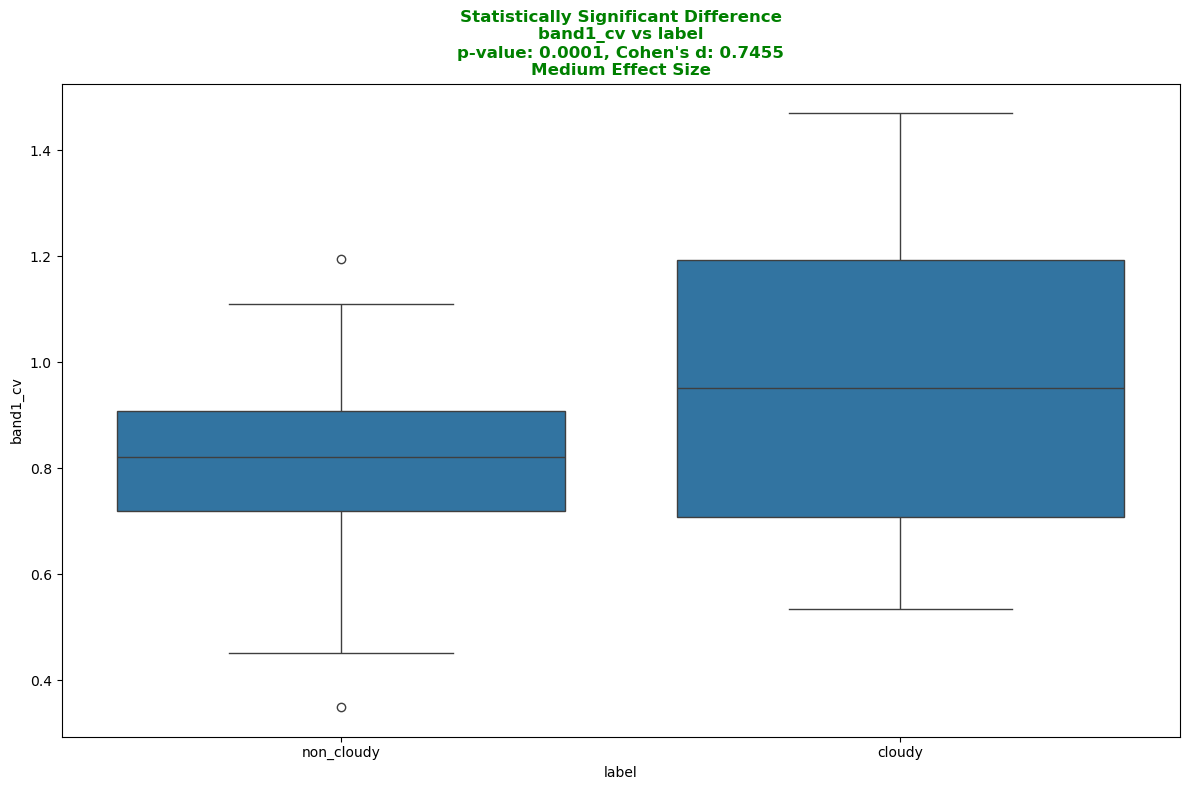

-----------------------------------------------------

Analysis for band2_cv vs label:

ANOVA Table:
            sum_sq     df          F        PR(>F)
C(label)  2.085262    1.0  73.190278  5.312997e-15
Residual  5.071393  178.0        NaN           NaN

Cohen's d: 1.6112 (Large effect)

The difference between groups is statistically significant (p=0.0000).


C:\Users\Abhishek\AppData\Local\Temp\ipykernel_29740\1495152865.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_table['F'][0]
C:\Users\Abhishek\AppData\Local\Temp\ipykernel_29740\1495152865.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]
C:\Users\Abhishek\AppData\Local\Temp\ipykernel_29740\1495152865.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  between_ss = anova_t

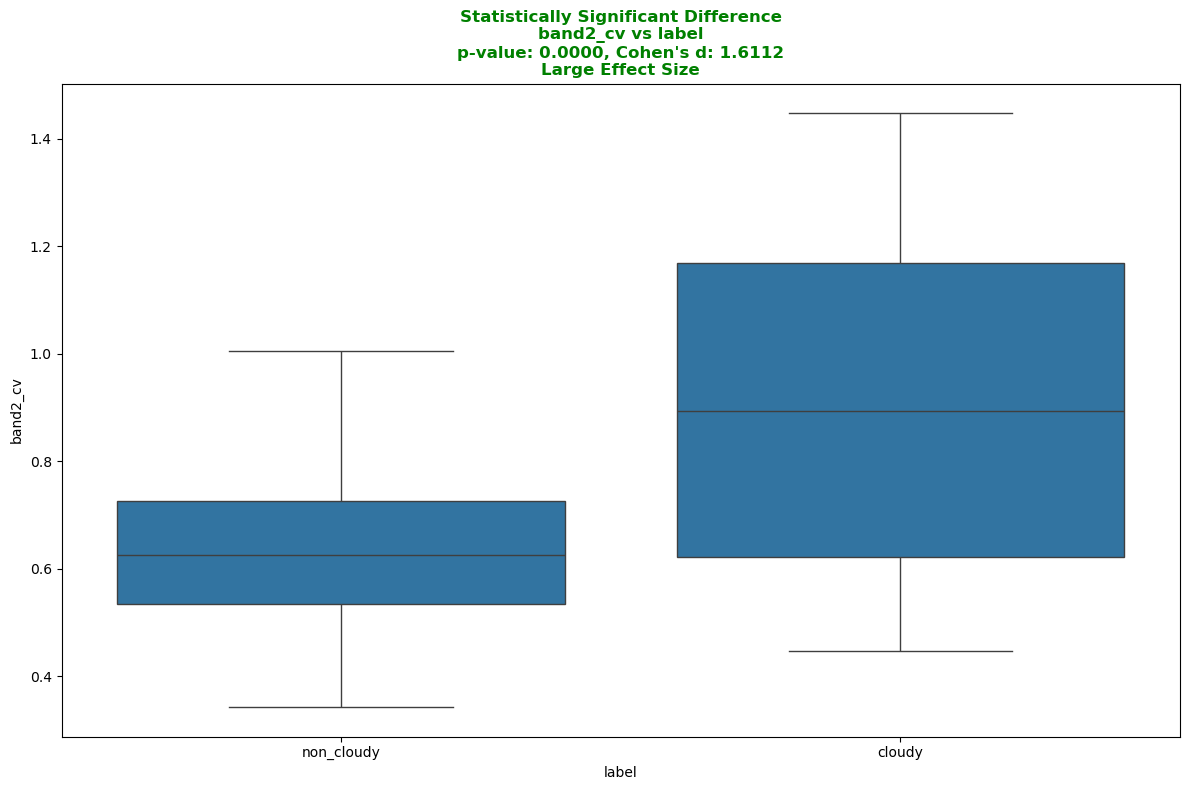

-----------------------------------------------------

Analysis for band3_cv vs label:

ANOVA Table:
            sum_sq     df          F        PR(>F)
C(label)  2.719872    1.0  64.516292  1.266696e-13
Residual  7.504108  178.0        NaN           NaN

Cohen's d: 1.5127 (Large effect)

The difference between groups is statistically significant (p=0.0000).


C:\Users\Abhishek\AppData\Local\Temp\ipykernel_29740\1495152865.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_table['F'][0]
C:\Users\Abhishek\AppData\Local\Temp\ipykernel_29740\1495152865.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]
C:\Users\Abhishek\AppData\Local\Temp\ipykernel_29740\1495152865.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  between_ss = anova_t

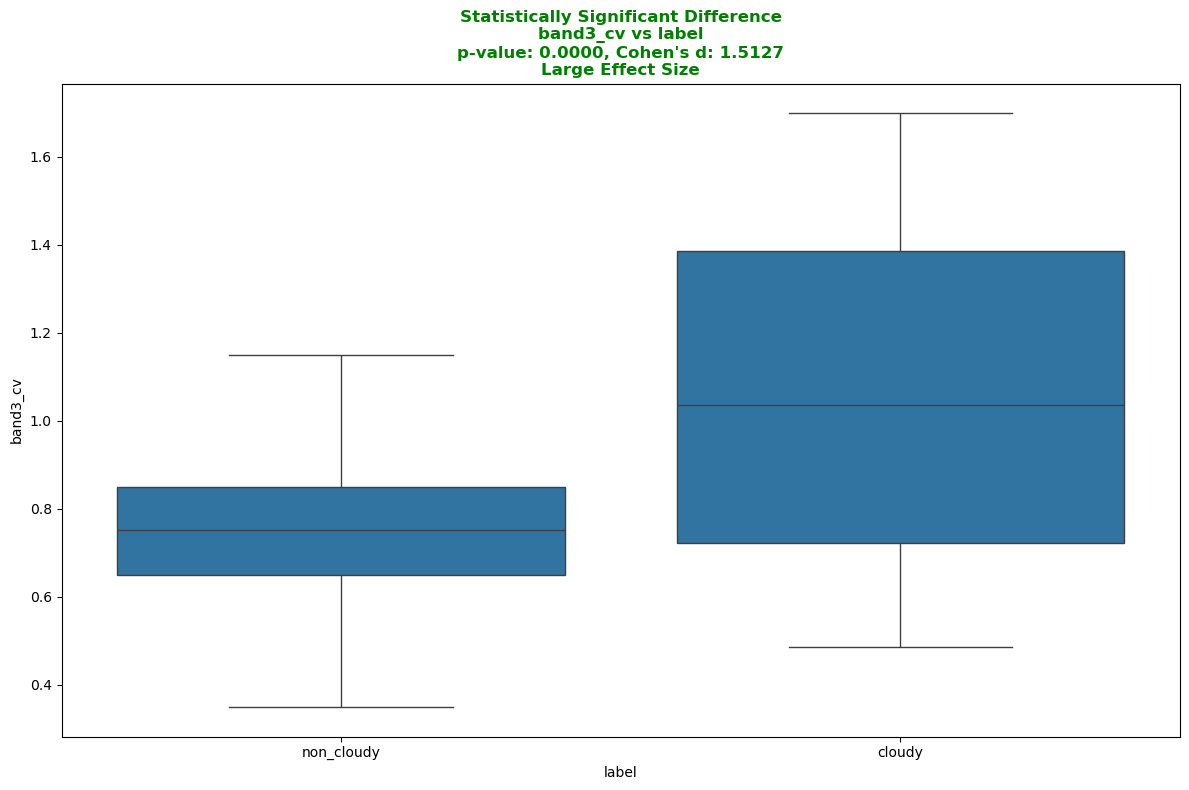

-----------------------------------------------------

Analysis for band4_cv vs label:

ANOVA Table:
            sum_sq     df         F   PR(>F)
C(label)  0.000230    1.0  0.026207  0.87158
Residual  1.560604  178.0       NaN      NaN

Cohen's d: 0.0305 (Negligible effect)

The difference between groups is not statistically significant (p=0.8716).


C:\Users\Abhishek\AppData\Local\Temp\ipykernel_29740\1495152865.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_table['F'][0]
C:\Users\Abhishek\AppData\Local\Temp\ipykernel_29740\1495152865.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]
C:\Users\Abhishek\AppData\Local\Temp\ipykernel_29740\1495152865.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  between_ss = anova_t

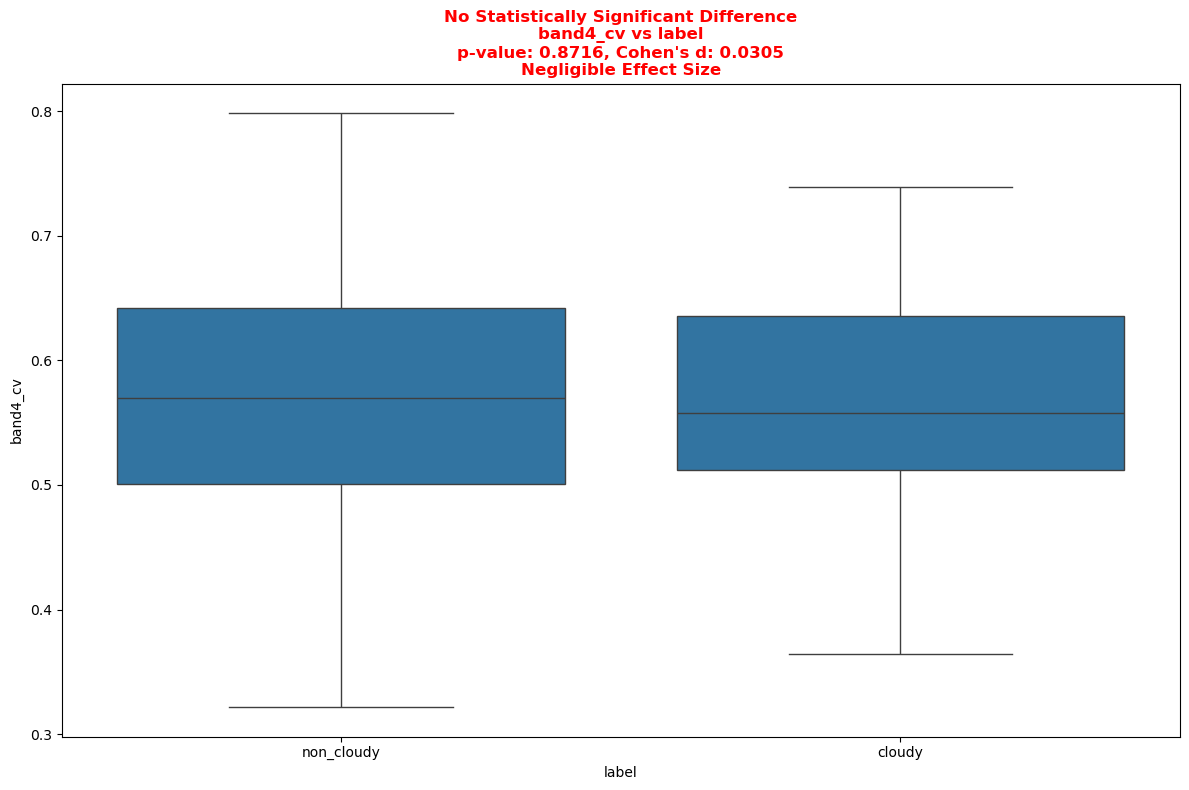

C:\Users\Abhishek\AppData\Local\Temp\ipykernel_29740\1495152865.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_table['F'][0]
C:\Users\Abhishek\AppData\Local\Temp\ipykernel_29740\1495152865.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]
C:\Users\Abhishek\AppData\Local\Temp\ipykernel_29740\1495152865.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  between_ss = anova_t

-----------------------------------------------------

Analysis for band5_cv vs label:

ANOVA Table:
            sum_sq     df          F        PR(>F)
C(label)  0.853410    1.0  44.809078  2.733042e-10
Residual  3.390094  178.0        NaN           NaN

Cohen's d: 1.2607 (Large effect)

The difference between groups is statistically significant (p=0.0000).


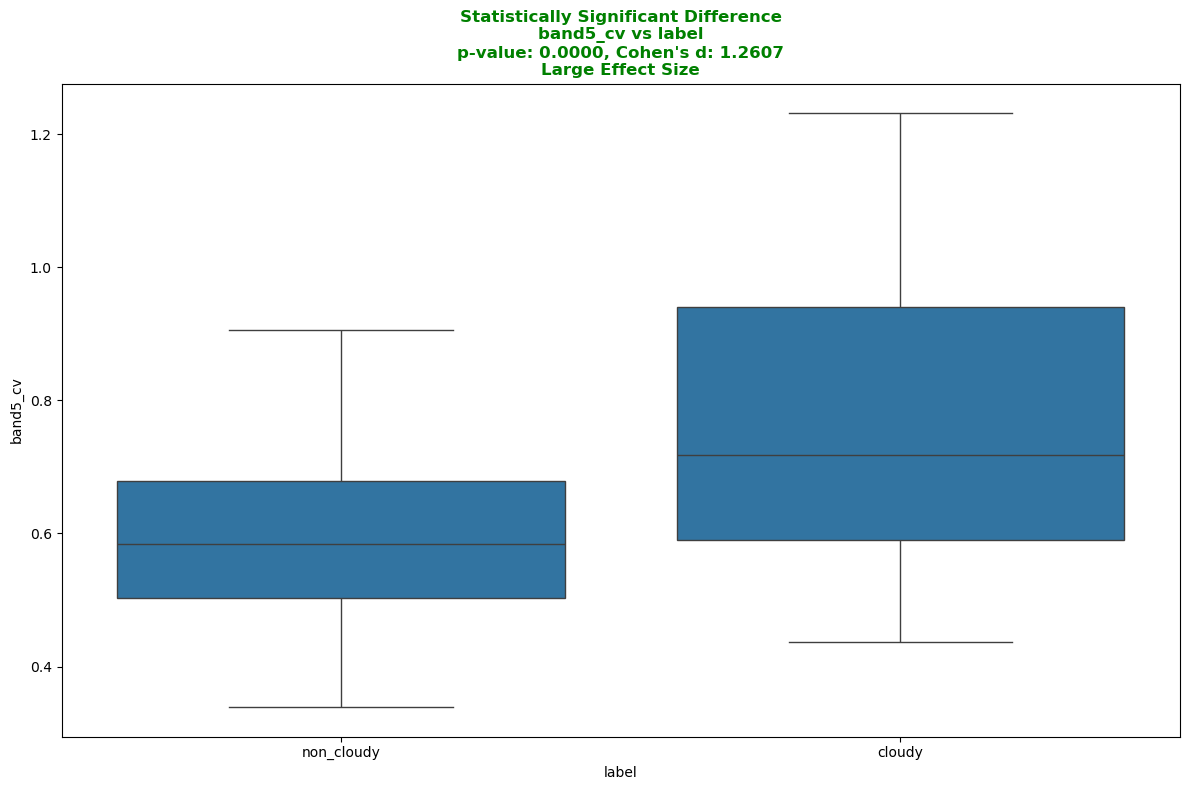

-----------------------------------------------------

Analysis for band6_cv vs label:

ANOVA Table:
            sum_sq     df         F    PR(>F)
C(label)  0.047514    1.0  4.520603  0.034867
Residual  1.870874  178.0       NaN       NaN

Cohen's d: 0.4004 (Small effect)

The difference between groups is statistically significant (p=0.0349).


C:\Users\Abhishek\AppData\Local\Temp\ipykernel_29740\1495152865.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_table['F'][0]
C:\Users\Abhishek\AppData\Local\Temp\ipykernel_29740\1495152865.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]
C:\Users\Abhishek\AppData\Local\Temp\ipykernel_29740\1495152865.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  between_ss = anova_t

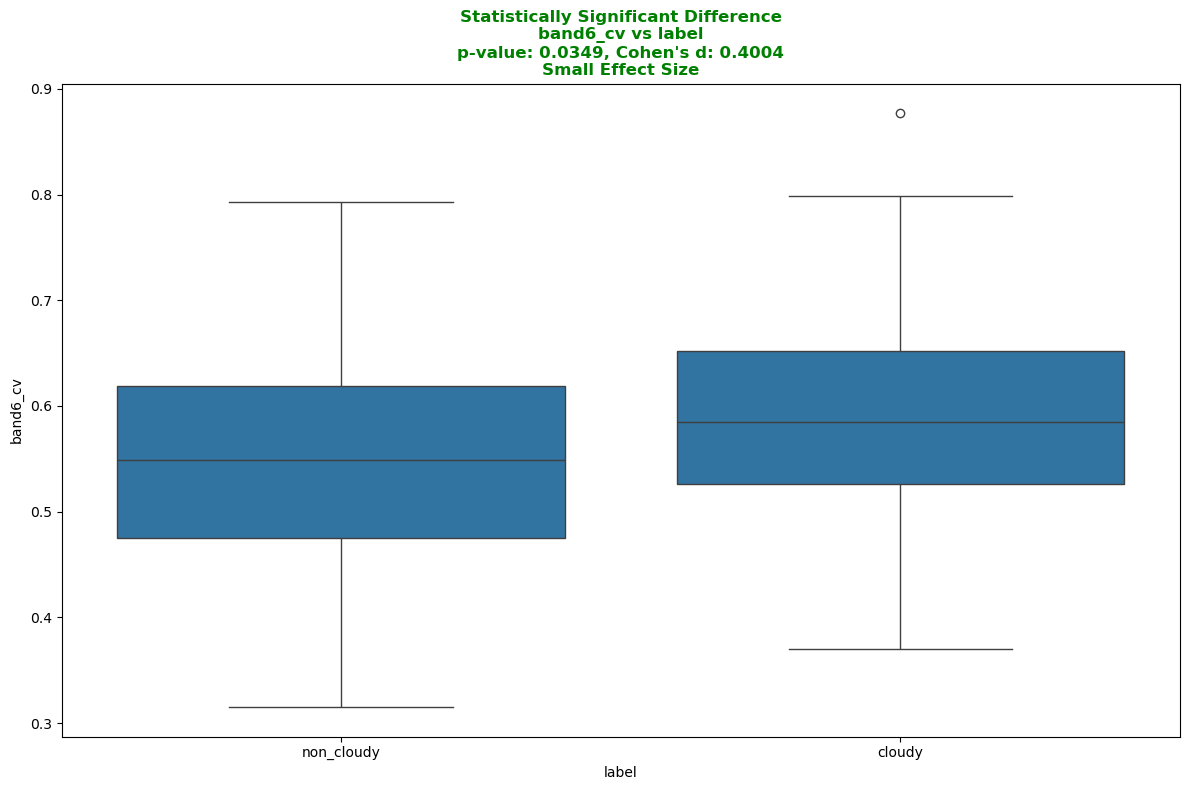

-----------------------------------------------------

Analysis for band7_cv vs label:

ANOVA Table:
            sum_sq     df         F    PR(>F)
C(label)  0.000945    1.0  0.099512  0.752785
Residual  1.690379  178.0       NaN       NaN

Cohen's d: 0.0594 (Negligible effect)

The difference between groups is not statistically significant (p=0.7528).


C:\Users\Abhishek\AppData\Local\Temp\ipykernel_29740\1495152865.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_table['F'][0]
C:\Users\Abhishek\AppData\Local\Temp\ipykernel_29740\1495152865.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]
C:\Users\Abhishek\AppData\Local\Temp\ipykernel_29740\1495152865.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  between_ss = anova_t

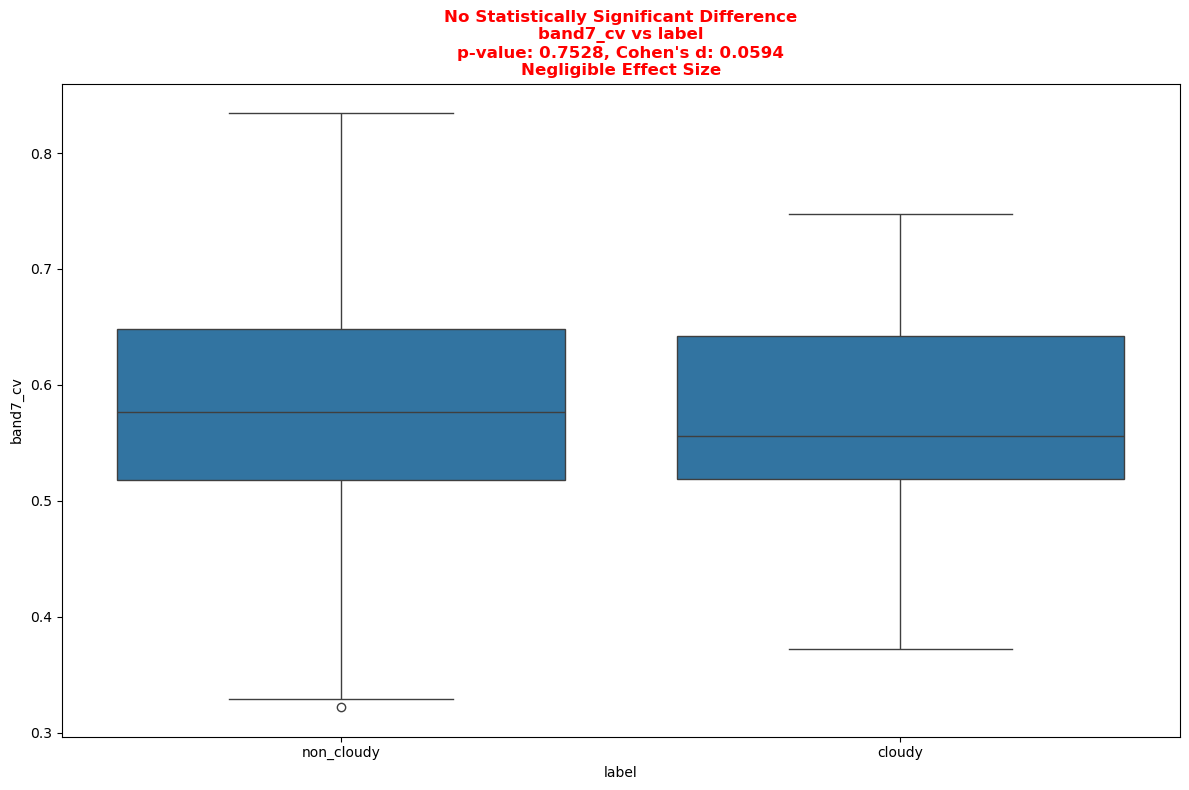

-----------------------------------------------------

Analysis for band8_cv vs label:

ANOVA Table:
            sum_sq     df         F    PR(>F)
C(label)  0.001516    1.0  0.179685  0.672156
Residual  1.502193  178.0       NaN       NaN

Cohen's d: 0.0798 (Negligible effect)

The difference between groups is not statistically significant (p=0.6722).


C:\Users\Abhishek\AppData\Local\Temp\ipykernel_29740\1495152865.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_table['F'][0]
C:\Users\Abhishek\AppData\Local\Temp\ipykernel_29740\1495152865.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]
C:\Users\Abhishek\AppData\Local\Temp\ipykernel_29740\1495152865.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  between_ss = anova_t

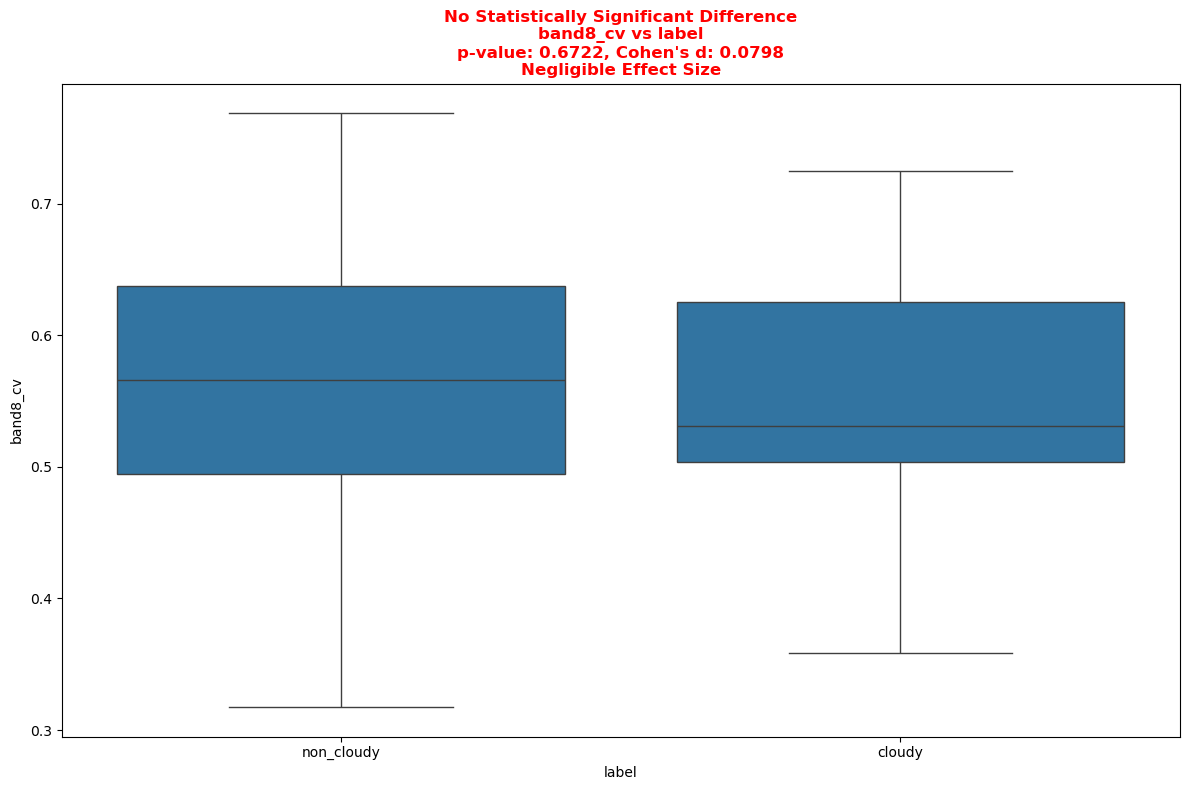

-----------------------------------------------------

Analysis for band9_cv vs label:

ANOVA Table:
            sum_sq     df         F    PR(>F)
C(label)  0.095606    1.0  7.650422  0.006275
Residual  2.224446  178.0       NaN       NaN

Cohen's d: 0.5209 (Medium effect)

The difference between groups is statistically significant (p=0.0063).


C:\Users\Abhishek\AppData\Local\Temp\ipykernel_29740\1495152865.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_table['F'][0]
C:\Users\Abhishek\AppData\Local\Temp\ipykernel_29740\1495152865.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]
C:\Users\Abhishek\AppData\Local\Temp\ipykernel_29740\1495152865.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  between_ss = anova_t

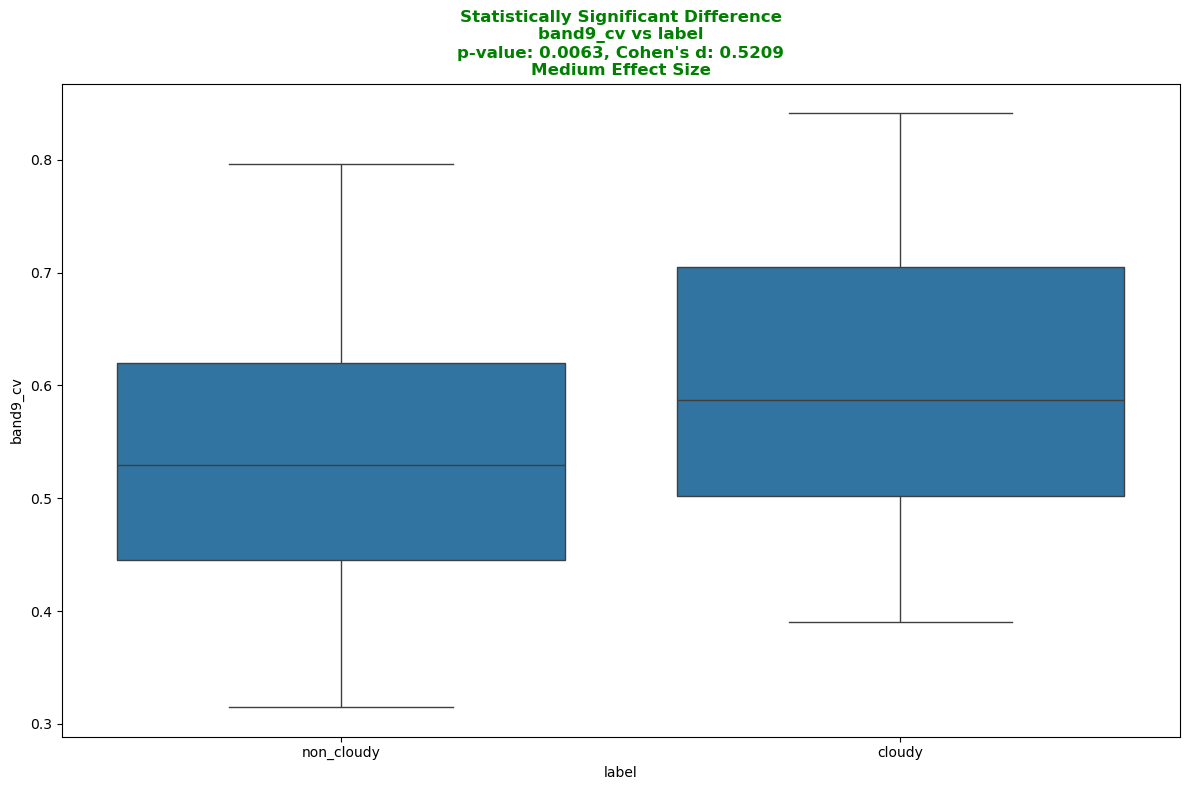

-----------------------------------------------------

Analysis for band10_cv vs label:

ANOVA Table:
            sum_sq     df         F    PR(>F)
C(label)  0.080570    1.0  3.371502  0.068001
Residual  4.253742  178.0       NaN       NaN

Cohen's d: 0.3458 (Small effect)

The difference between groups is not statistically significant (p=0.0680).


C:\Users\Abhishek\AppData\Local\Temp\ipykernel_29740\1495152865.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_table['F'][0]
C:\Users\Abhishek\AppData\Local\Temp\ipykernel_29740\1495152865.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]
C:\Users\Abhishek\AppData\Local\Temp\ipykernel_29740\1495152865.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  between_ss = anova_t

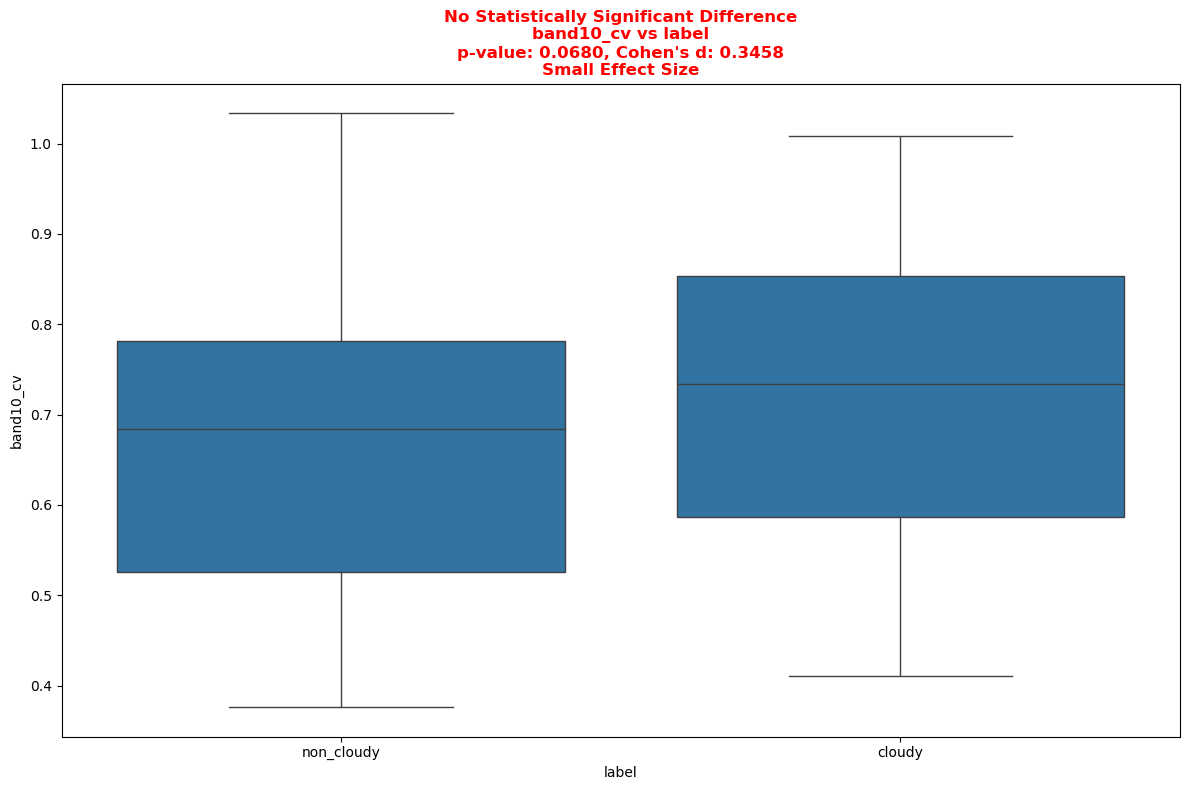

-----------------------------------------------------

ANALYSIS SUMMARY

Significant band-label pairs (6):
- band1_cv vs label
- band2_cv vs label
- band3_cv vs label
- band5_cv vs label
- band6_cv vs label
- band9_cv vs label

Non-significant band-label pairs (4):
- band4_cv vs label
- band7_cv vs label
- band8_cv vs label
- band10_cv vs label


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

def anova_and_boxplot(df, numerical_cols, categorical_cols, alpha=0.05):
    significant_pairs = []
    nonsignificant_pairs = []
   
    for num_col in numerical_cols:
        for cat_col in categorical_cols:
            print(f"\nAnalysis for {num_col} vs {cat_col}:")
           
            # Perform one-way ANOVA
            formula = f"{num_col} ~ C({cat_col})"
            model = ols(formula, data=df).fit()
            anova_table = anova_lm(model, typ=2)
           
            # Extract relevant statistics
            f_value = anova_table['F'][0]
            p_value = anova_table['PR(>F)'][0]
            between_ss = anova_table['sum_sq'][0]
            within_ss = anova_table['sum_sq'][1]
            between_df = anova_table['df'][0]
            within_df = anova_table['df'][1]
           
            # Calculate Cohen's d
            groups = df.groupby(cat_col)[num_col]
            group_means = groups.mean()
            overall_std = np.sqrt(within_ss / within_df)
            max_mean = group_means.max()
            min_mean = group_means.min()
            cohens_d = (max_mean - min_mean) / overall_std
           
            # Interpret Cohen's d
            if abs(cohens_d) < 0.2:
                effect_size = "Negligible"
            elif abs(cohens_d) < 0.5:
                effect_size = "Small"
            elif abs(cohens_d) < 0.8:
                effect_size = "Medium"
            else:
                effect_size = "Large"
           
            # Print ANOVA table
            print("\nANOVA Table:")
            print(anova_table)
           
            print(f"\nCohen's d: {cohens_d:.4f} ({effect_size} effect)")
           
            # Check significance
            if p_value < alpha:
                print(f"\nThe difference between groups is statistically significant (p={p_value:.4f}).")
                significant_pairs.append((num_col, cat_col))
                significance = "Statistically Significant Difference"
                color = 'green'
            else:
                print(f"\nThe difference between groups is not statistically significant (p={p_value:.4f}).")
                nonsignificant_pairs.append((num_col, cat_col))
                significance = "No Statistically Significant Difference"
                color = 'red'
           
            # Create grouped box plot
            plt.figure(figsize=(12, 8))
            sns.boxplot(x=cat_col, y=num_col, data=df)
            plt.xlabel(cat_col)
            plt.ylabel(num_col)
           
            plt.title(f"{significance}\n{num_col} vs {cat_col}\np-value: {p_value:.4f}, Cohen's d: {cohens_d:.4f}\n{effect_size} Effect Size",
                      color=color, fontweight='bold')
           
            plt.tight_layout()
            plt.show()
           
            print("-----------------------------------------------------")
   
    return significant_pairs, nonsignificant_pairs

# Load the cloud detection dataframe created earlier
df = pd.read_csv("cloud_detection_cv_features.csv")

# Print dataframe information
print("Cloud Detection Dataset:")
print(f"Total samples: {len(df)}")
print(f"Cloudy images: {sum(df['label'] == 'cloudy')}")
print(f"Non-cloudy images: {sum(df['label'] == 'non_cloudy')}")
print("\nDataframe columns:")
print(df.columns.tolist())

# Define numerical columns (band CV columns)
numerical_cols = [col for col in df.columns if col.startswith('band') and col.endswith('_cv')]
print(f"\nNumerical columns (band CVs): {numerical_cols}")

# Define categorical columns
categorical_cols = ['label']
print(f"Categorical columns: {categorical_cols}")

# Run ANOVA analysis with boxplots
print("\n" + "="*50)
print("RUNNING ANOVA ANALYSIS WITH BOXPLOTS")
print("="*50)

significant_pairs, nonsignificant_pairs = anova_and_boxplot(df, numerical_cols, categorical_cols)

# Print summary
print("\n" + "="*50)
print("ANALYSIS SUMMARY")
print("="*50)

print(f"\nSignificant band-label pairs ({len(significant_pairs)}):")
for num_col, cat_col in significant_pairs:
    print(f"- {num_col} vs {cat_col}")

print(f"\nNon-significant band-label pairs ({len(nonsignificant_pairs)}):")
for num_col, cat_col in nonsignificant_pairs:
    print(f"- {num_col} vs {cat_col}")

**Six spectral bands show statistically significant differences** between cloudy and non-cloudy images: bands 1, 2, 3, 5, 6, and 9. This finding is particularly valuable as it identifies the most cloud-sensitive bands for wetland segmentation preprocessing. Band 2 (blue) and band 3 (green) significance aligns with their known sensitivity to atmospheric conditions, while the significance of band 9 (water vapor) provides a direct measure of atmospheric moisture content. <br>

Four bands (4, 7, 8, and 10) showed no statistically significant difference between cloudy and non-cloudy images, suggesting these bands may be more robust to cloud interference. This insight enables development of **cloud-resistant feature combinations** for improved wetland detection under variable atmospheric conditions. <br>

The methodology employs comprehensive statistical rigor through both p-value significance testing and effect size quantification using Cohen's d, providing confidence in the identified band sensitivities. These findings directly inform the wetland segmentation pipeline by enabling intelligent band selection and weighting strategies that can minimize cloud interference effects while maximizing wetland feature detection capabilities.

## Cloudy Image model

**Cloud Detection Model for Wetland Segmentation Preprocessing** <br>

The cloud detection pipeline employs multiple machine learning algorithms to classify image patches as cloudy or non-cloudy based on spectral band coefficient of variation (CV) features. This preprocessing step is crucial for ensuring high-quality inputs for wetland segmentation modeling. <br>

The data was split into training (144 samples) and testing (36 samples) sets, maintaining a similar class distribution of approximately 20% cloudy images. 

Training set size: 144
Testing set size: 36
Cloudy samples in training: label
0    115
1     29
Name: count, dtype: int64, label
0    0.798611
1    0.201389
Name: proportion, dtype: float64
Cloudy samples in test: label
0    30
1     6
Name: count, dtype: int64, label
0    0.833333
1    0.166667
Name: proportion, dtype: float64

Training Random Forest...

Training XGBoost...

Training LightGBM...
[LightGBM] [Info] Number of positive: 29, number of negative: 115
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 488
[LightGBM] [Info] Number of data points in the train set: 144, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201389 -> initscore=-1.377636
[LightGBM] [Info] Start training from score -1.377636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

C:\Users\Abhishek\AppData\Roaming\Python\Python312\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


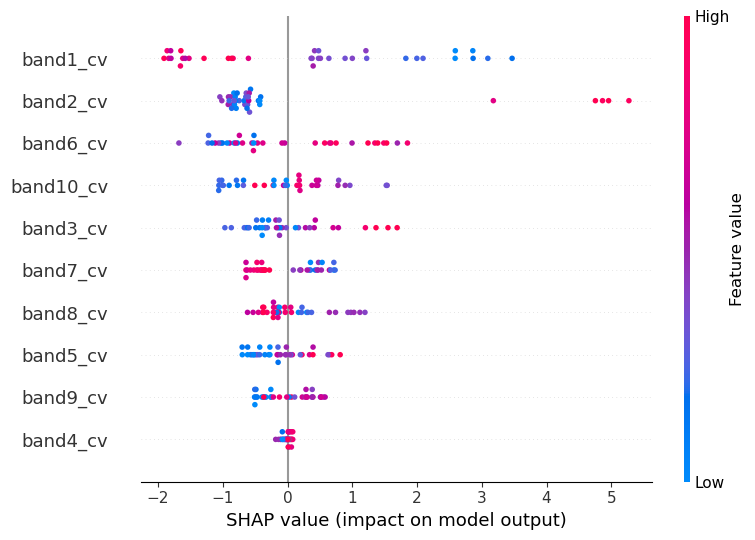

<Figure size 640x480 with 0 Axes>

C:\Users\Abhishek\AppData\Roaming\Python\Python312\site-packages\lightgbm\basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


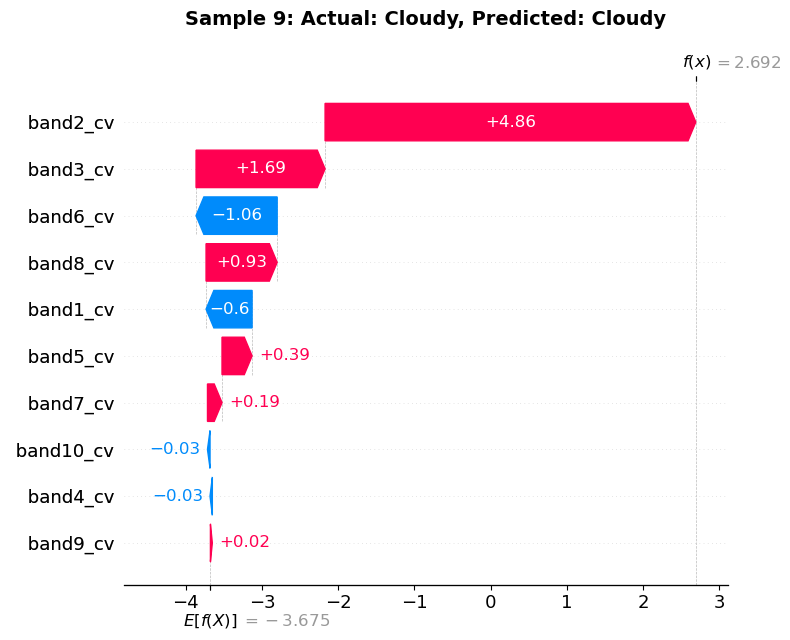

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import shap
import rasterio
from rasterio.plot import show


# Load the cloud detection dataframe
df = pd.read_csv("cloud_detection_cv_features.csv")

# Define features and target
X = df[[col for col in df.columns if col.startswith('band') and col.endswith('_cv')]]
y = (df['label'] == 'cloudy').astype(int)  # 1 for cloudy, 0 for non_cloudy

# Split the data into training and testing sets (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"Cloudy samples in training: {y_train.value_counts()}, {y_train.value_counts(normalize=True)}")
print(f"Cloudy samples in test: {y_test.value_counts()}, {y_test.value_counts(normalize=True)}")

# Define the models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0)
}

# Results dataframes for both train and test
train_results = []
test_results = []

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    
    # --- TRAIN SET EVALUATION ---
    # Make predictions on training set
    y_pred_train = model.predict(X_train)
    
    # Calculate confusion matrix for training set
    tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_pred_train).ravel()
    
    # Calculate metrics for training set
    precision_train = precision_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train)
    
    # Add results to train list
    train_results.append({
        'model': name,
        'tp': tp_train,
        'tn': tn_train,
        'fp': fp_train,
        'fn': fn_train,
        'precision': precision_train,
        'recall': recall_train,
        'f1_score': f1_train
    })
    
    # --- TEST SET EVALUATION ---
    # Make predictions on test set
    y_pred_test = model.predict(X_test)
    
    # Calculate confusion matrix for test set
    tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_pred_test).ravel()
    
    # Calculate metrics for test set
    precision_test = precision_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    
    # Add results to test list
    test_results.append({
        'model': name,
        'tp': tp_test,
        'tn': tn_test,
        'fp': fp_test,
        'fn': fn_test,
        'precision': precision_test,
        'recall': recall_test,
        'f1_score': f1_test
    })

# Create results dataframes
train_results_df = pd.DataFrame(train_results)
train_results_df = train_results_df.sort_values('f1_score', ascending=False)

test_results_df = pd.DataFrame(test_results)
test_results_df = test_results_df.sort_values('f1_score', ascending=False)

print("\nModel Comparison on TRAINING Set (sorted by F1 score):")
print(train_results_df)

print("\nModel Comparison on TEST Set (sorted by F1 score):")
print(test_results_df)

# Print the best model based on test performance
best_model = test_results_df.iloc[0]['model']
print(f"\nBest model based on test F1 score: {best_model}")

# Feature importance / SHAP values for the best model
best_model_name = test_results_df.iloc[0]['model']
best_model_obj = models[best_model_name]

# Save the model
import joblib
model_filename = f"cloud_detection_{best_model_name.lower().replace(' ', '_')}.joblib"
joblib.dump(best_model_obj, model_filename)
print(f"Best model saved to {model_filename}")


print(f"\nGenerating feature importance and SHAP values for {best_model_name}...")

# Check if the best model is Random Forest and show feature importance
if best_model_name == 'Random Forest':
    feature_importance = best_model_obj.feature_importances_
    features = X.columns
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
    importance_df = importance_df.sort_values('Importance', ascending=False)
    print("\nTop 5 most important features (Random Forest):")
    print(importance_df.head(5))

# SHAP values for any model type
# Create the SHAP explainer based on the model type
if best_model_name == 'Random Forest':
    explainer = shap.TreeExplainer(best_model_obj)
elif best_model_name == 'XGBoost':
    explainer = shap.TreeExplainer(best_model_obj)
elif best_model_name == 'LightGBM':
    explainer = shap.TreeExplainer(best_model_obj)
elif best_model_name == 'CatBoost':
    explainer = shap.TreeExplainer(best_model_obj)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Handle different outputs from explainer
if isinstance(shap_values, list):
    # For models that return a list (e.g., for binary classification)
    shap_values_for_class1 = shap_values[1] if len(shap_values) > 1 else shap_values[0]
else:
    # For models that return a single array
    shap_values_for_class1 = shap_values

# Global interpretation - SHAP summary plot
plt.figure(figsize=(10, 8))
print("\nSHAP Summary Plot (Global Interpretation):")
shap.summary_plot(shap_values_for_class1, X_test)
plt.tight_layout()
plt.show()

# Local interpretation - SHAP waterfall plot for an individual example
# Choose a specific sample for explanation (e.g., the first cloudy sample in test set)
cloudy_indices = [i for i, val in enumerate(y_test) if val == 1]
if cloudy_indices:  # If there are cloudy samples in the test set
    sample_idx = cloudy_indices[0]
else:  # Otherwise, just use the first sample
    sample_idx = 0

# Get actual and predicted class for the sample
actual_class = "Cloudy" if y_test.iloc[sample_idx] == 1 else "Non-Cloudy"
y_pred = best_model_obj.predict(X_test.iloc[sample_idx].values.reshape(1, -1))
predicted_class = "Cloudy" if y_pred[0] == 1 else "Non-Cloudy"

# Create a figure with a subplot layout for the SHAP waterfall plot
fig = plt.figure(figsize=(12, 10))

# Add the waterfall plot to the figure
ax = fig.add_subplot(111)
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value if not isinstance(explainer.expected_value, list) 
    else explainer.expected_value[1 if len(explainer.expected_value) > 1 else 0],
    shap_values_for_class1[sample_idx],
    X_test.iloc[sample_idx],
    feature_names=X_test.columns.tolist(),
    max_display=10,
    show=False
)

# Add title with prediction information inside the plot
plt.title(f"Sample {sample_idx}: Actual: {actual_class}, Predicted: {predicted_class}", 
          fontsize=14, fontweight='bold', pad=20)



plt.tight_layout()
plt.show()




While all models achieved **perfect performance on the training data** (F1 score of 1.0), the **LightGBM classifier demonstrated superior generalization** on the test set with the highest F1 score of 0.77, outperforming XGBoost, CatBoost, and Random Forest. <br>

The SHAP value analysis reveals that **band2_cv (blue band) is the most influential feature** for cloud detection, showing consistently high positive impact values above +4.8 in the sample explanation. This aligns with atmospheric optics principles, as blue light is most susceptible to cloud-based scattering. Band3_cv (green) provides the second-strongest signal with a substantial contribution of +1.69. <br>

Interestingly, some bands exhibit negative SHAP values (band6_cv, band1_cv), indicating they can counteract false cloud detections when their CV values are within certain ranges. The waterfall plot demonstrates how the model integrates these competing signals to arrive at accurate cloud predictions. <br>

This cloud detection model serves as a **critical quality control mechanism** in the wetland segmentation pipeline, enabling the identification and potential exclusion or special handling of cloud-affected images that could otherwise introduce noise into the segmentation results. The saved model can be integrated into the preprocessing workflow to systematically filter the 180-patch dataset for optimal segmentation performance.